In [1]:
import mesa
import math
import numpy as np
from model import Evacuation
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm

In [2]:
sns.set_theme(style = "whitegrid", palette = "Pastel1")

In [3]:
#Evacuation(n=10, width=20, height=10, door_width = 4, seed=10, model_type = "BNE_mixed_SR", p_BNE = 100)

def batch_run(params):

    if __name__ == '__main__':
        results = mesa.batch_run(
            Evacuation,
            parameters=params,
            iterations=50,
            max_steps=500,
            number_processes=8,
            data_collection_period=-1,
            display_progress=1
        )

    results_df = pd.DataFrame(results)
    ev_times = results_df.groupby("RunId").first().Step
    return ev_times

### Czas ewakuacji dla ustalonego otoczenia i liczby pieszych w zależności od algorytmu

#### box ploty

In [16]:
results_box_bne = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_SR", "p_BNE": 100})

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
results_box_rf = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_RF", "p_BNE": 0})

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
results_box_sr = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_SR", "p_BNE": 0})

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
box_df = pd.DataFrame(
    {   "model_type": np.concatenate((np.full(50, "BNE"), np.full(50, "RF"), np.full(50, "SR"))),
        "exit_time": np.concatenate((results_box_bne.values, results_box_rf.values, results_box_sr.values))
    })
box_df

,model_type,exit_time
0,BNE,106
1,BNE,108
2,BNE,500
3,BNE,109
4,BNE,110
...,...,...
145,SR,204
146,SR,236
147,SR,218
148,SR,226


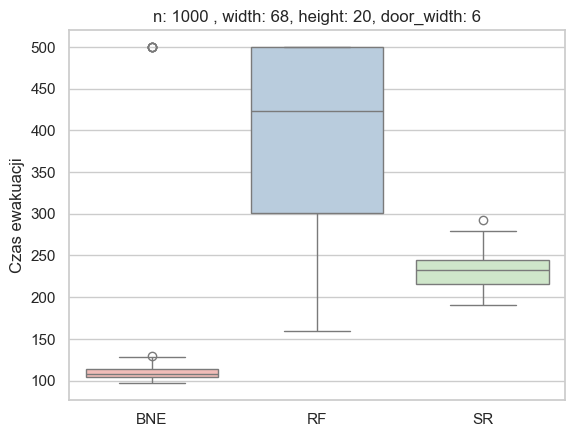

In [ ]:
sns.boxplot( np.array([results_box_bne, results_box_rf, results_box_sr]).T)
plt.xticks(np.arange(3), ["BNE", "RF", "SR"])
plt.title("n: 1000 , width: 68, height: 20, door_width: 6")
plt.ylabel("Czas ewakuacji")
plt.show()

#### Przykładowe klatki z różnych metod

In [48]:
import matplotlib.colors as mplc
import matplotlib as mpl
def frames(method):
    
    model_type = method[0]
    p_bne = method[1]

    frames_nums = [0, 20, 40, 60, 80, 100 ]
    model = Evacuation(n = 1000, width = 68, height = 20, door_width = 6, seed = 10, model_type=model_type, p_BNE = p_bne)

    agent_counts = np.zeros((model.grid.width, model.grid.height))
    step_num=0
    while model.running:
        for cell_content, (x, y) in model.grid.coord_iter():
            agent_count = len(cell_content)
            agent_counts[x][y] = agent_count
        model.step()
        if step_num in frames_nums:
            plt.figure(figsize=(model.grid.width, model.grid.height))
            sns.set_style('dark', {"axes.facecolor": "0.95"})
            sns.heatmap(agent_counts.T, cmap="mako_r", annot=True, cbar=True, norm = mplc.LogNorm(vmin=1, vmax=25))
            plt.gca().invert_yaxis()
            plt.title(f"{model_type} step {step_num}")
            plt.show()
        step_num +=1

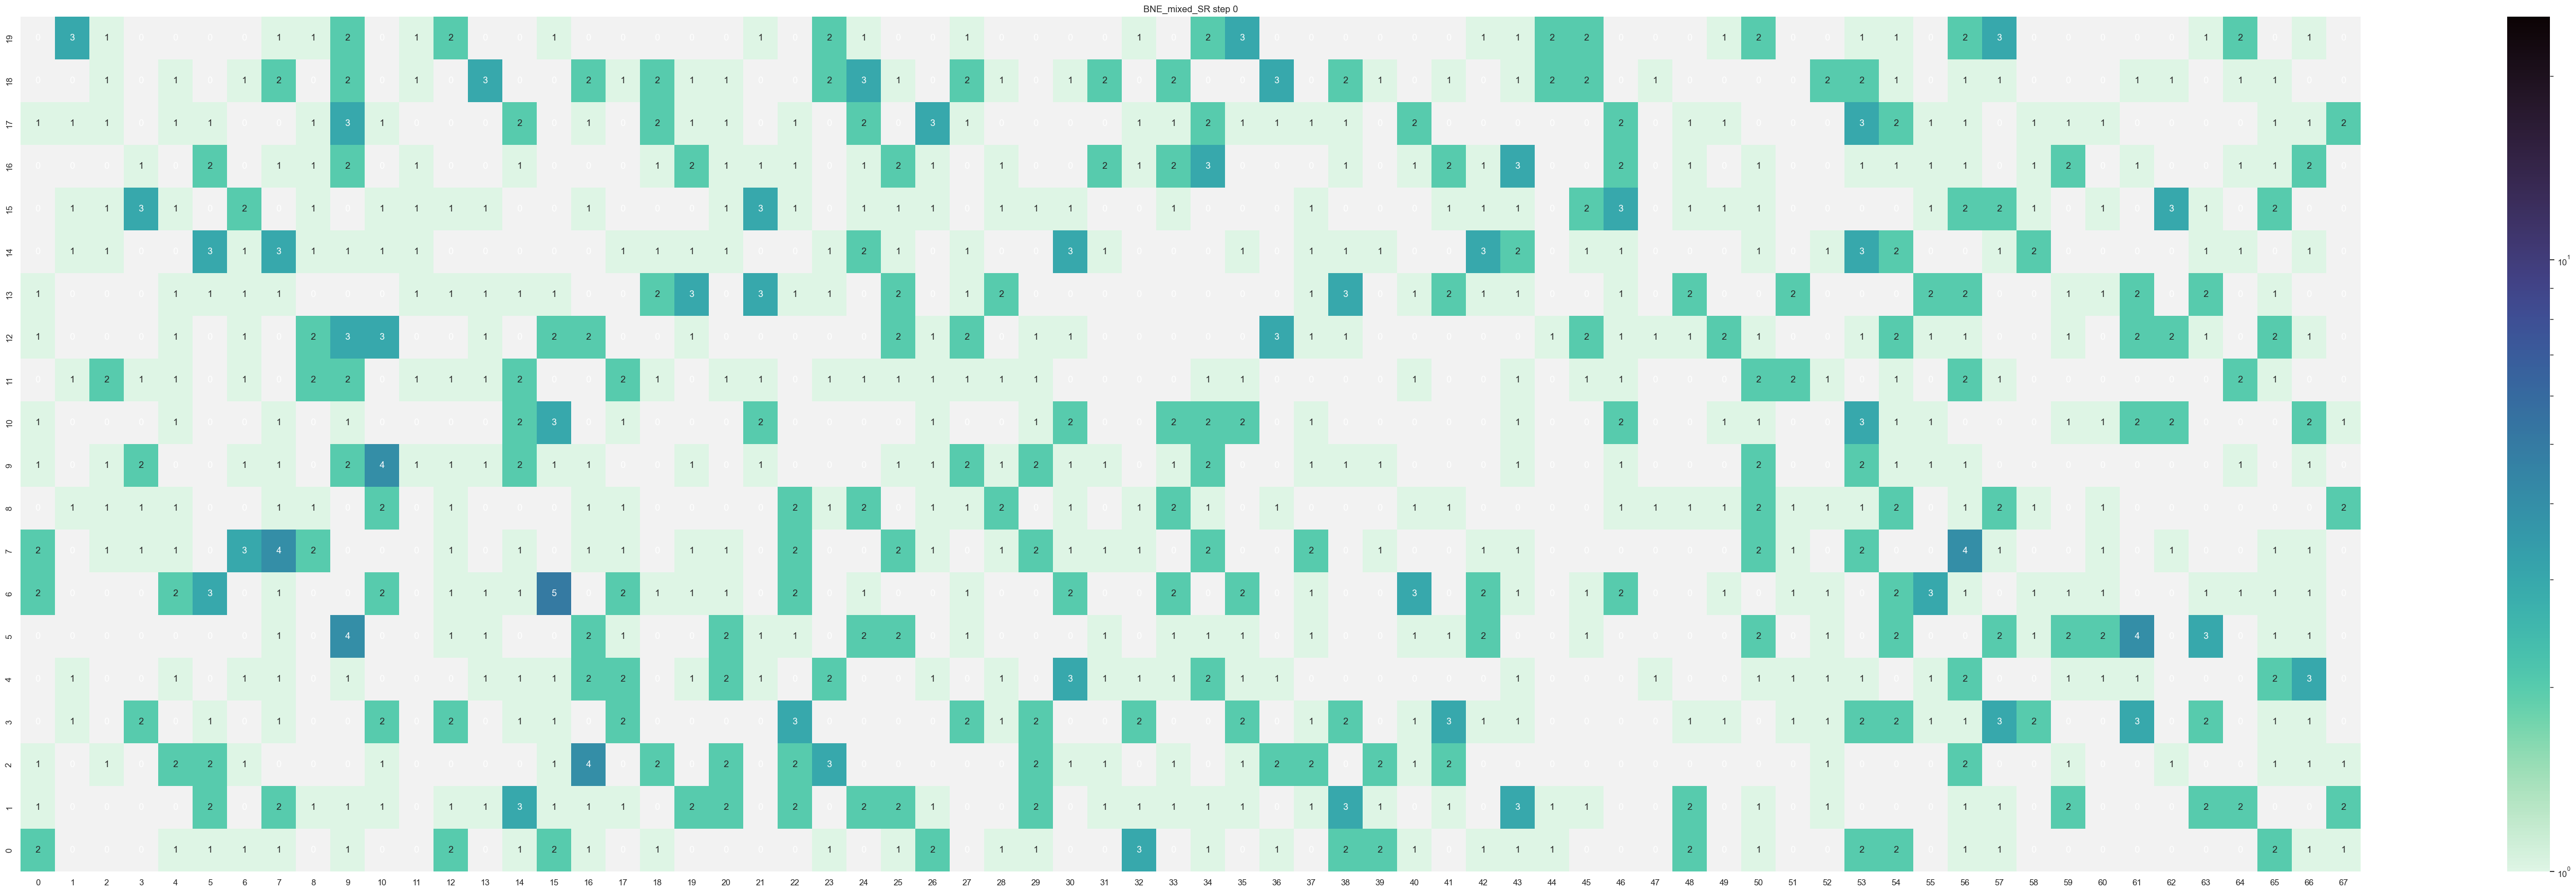

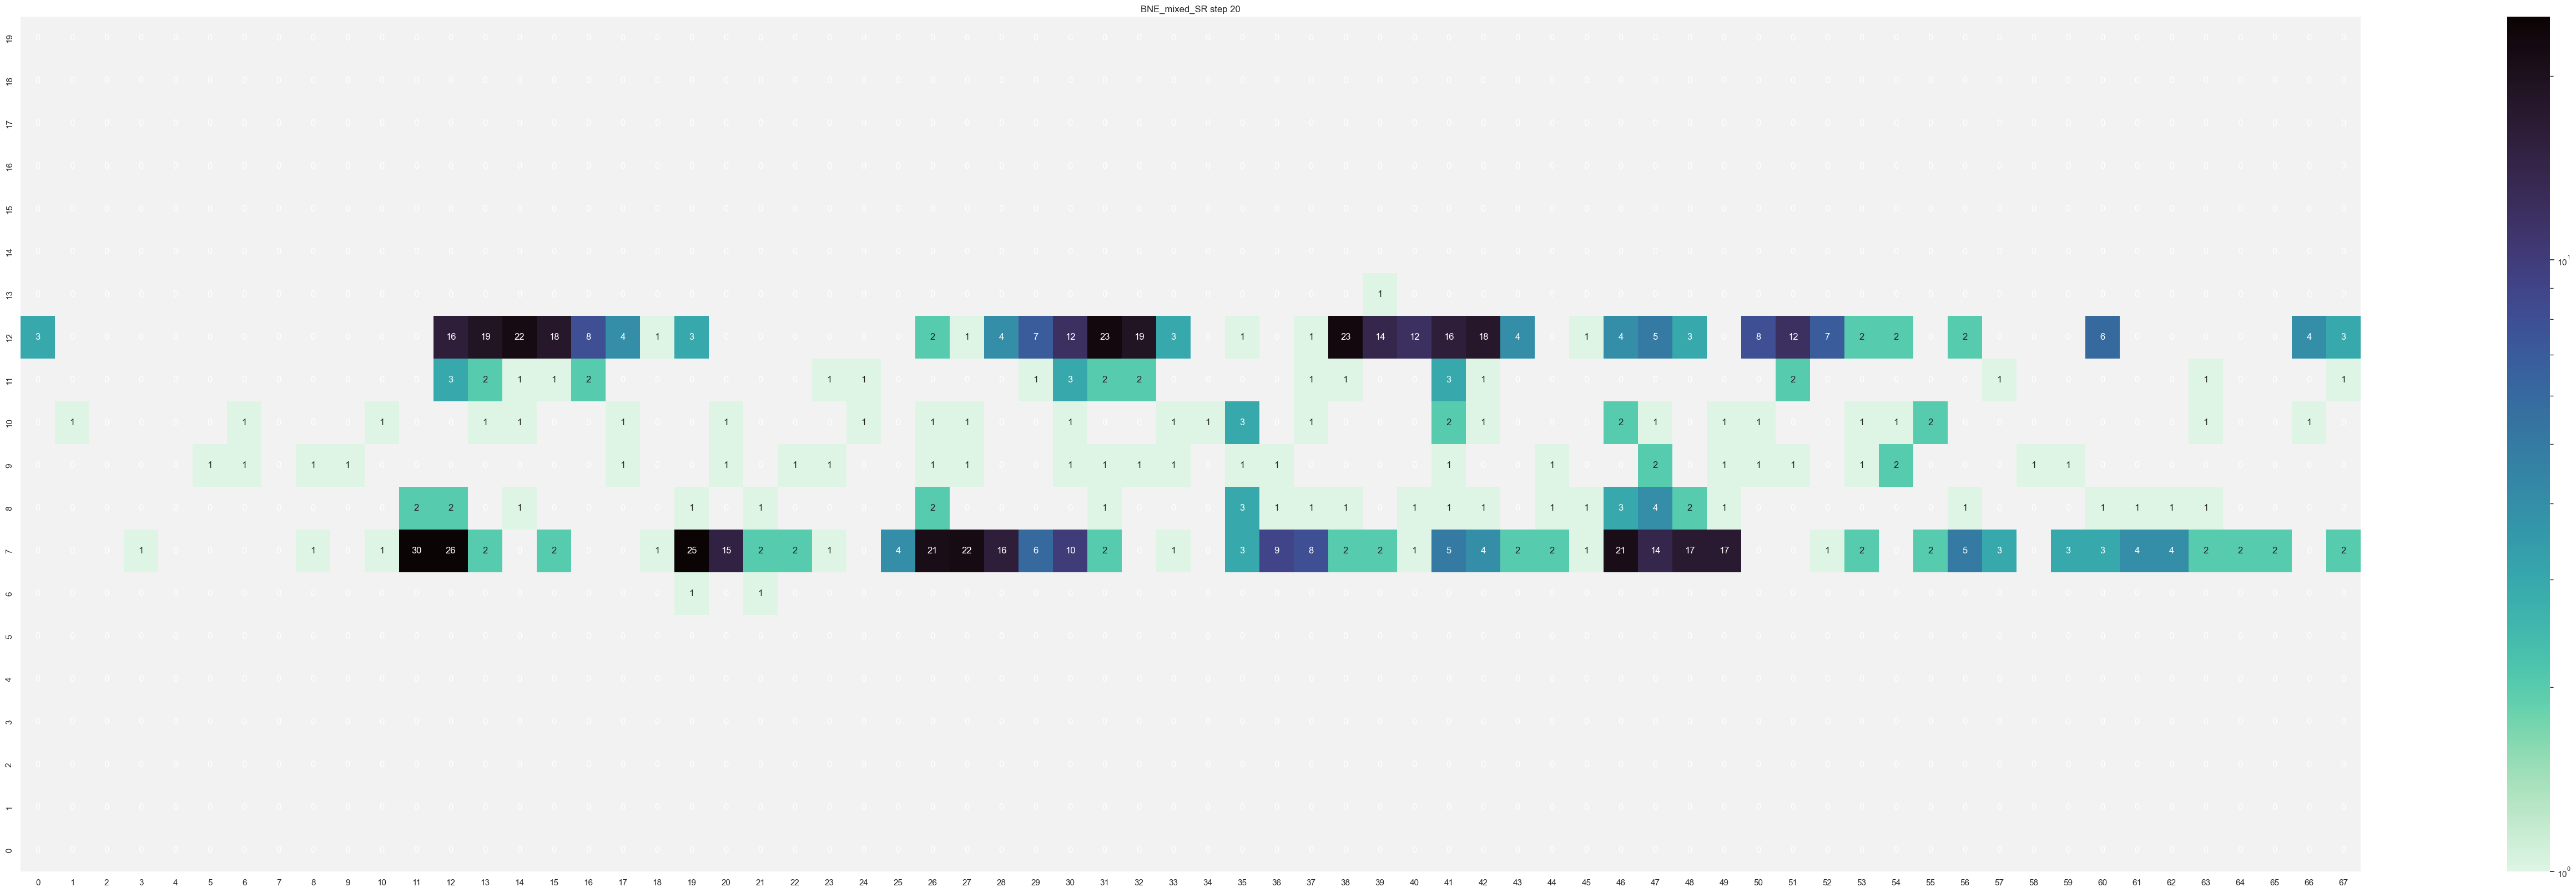

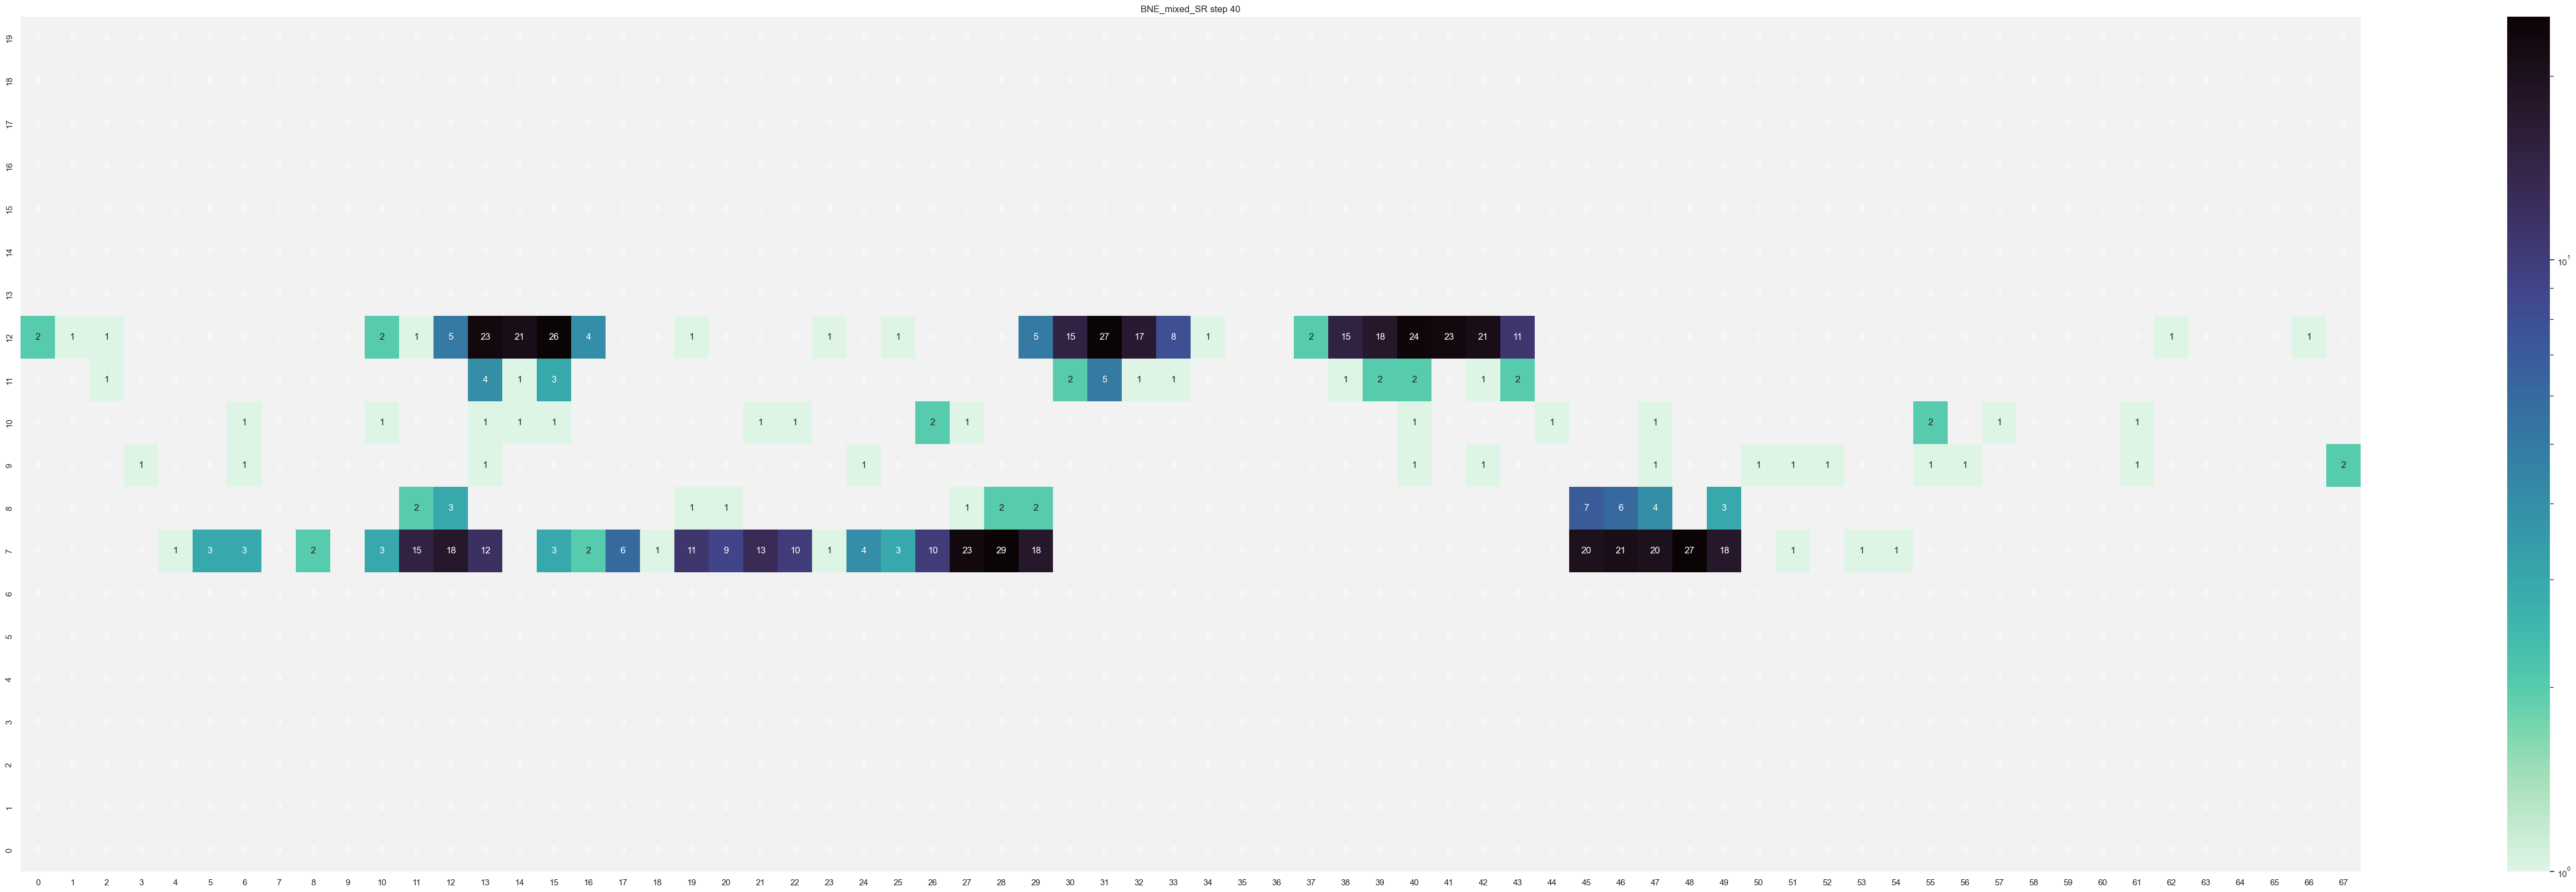

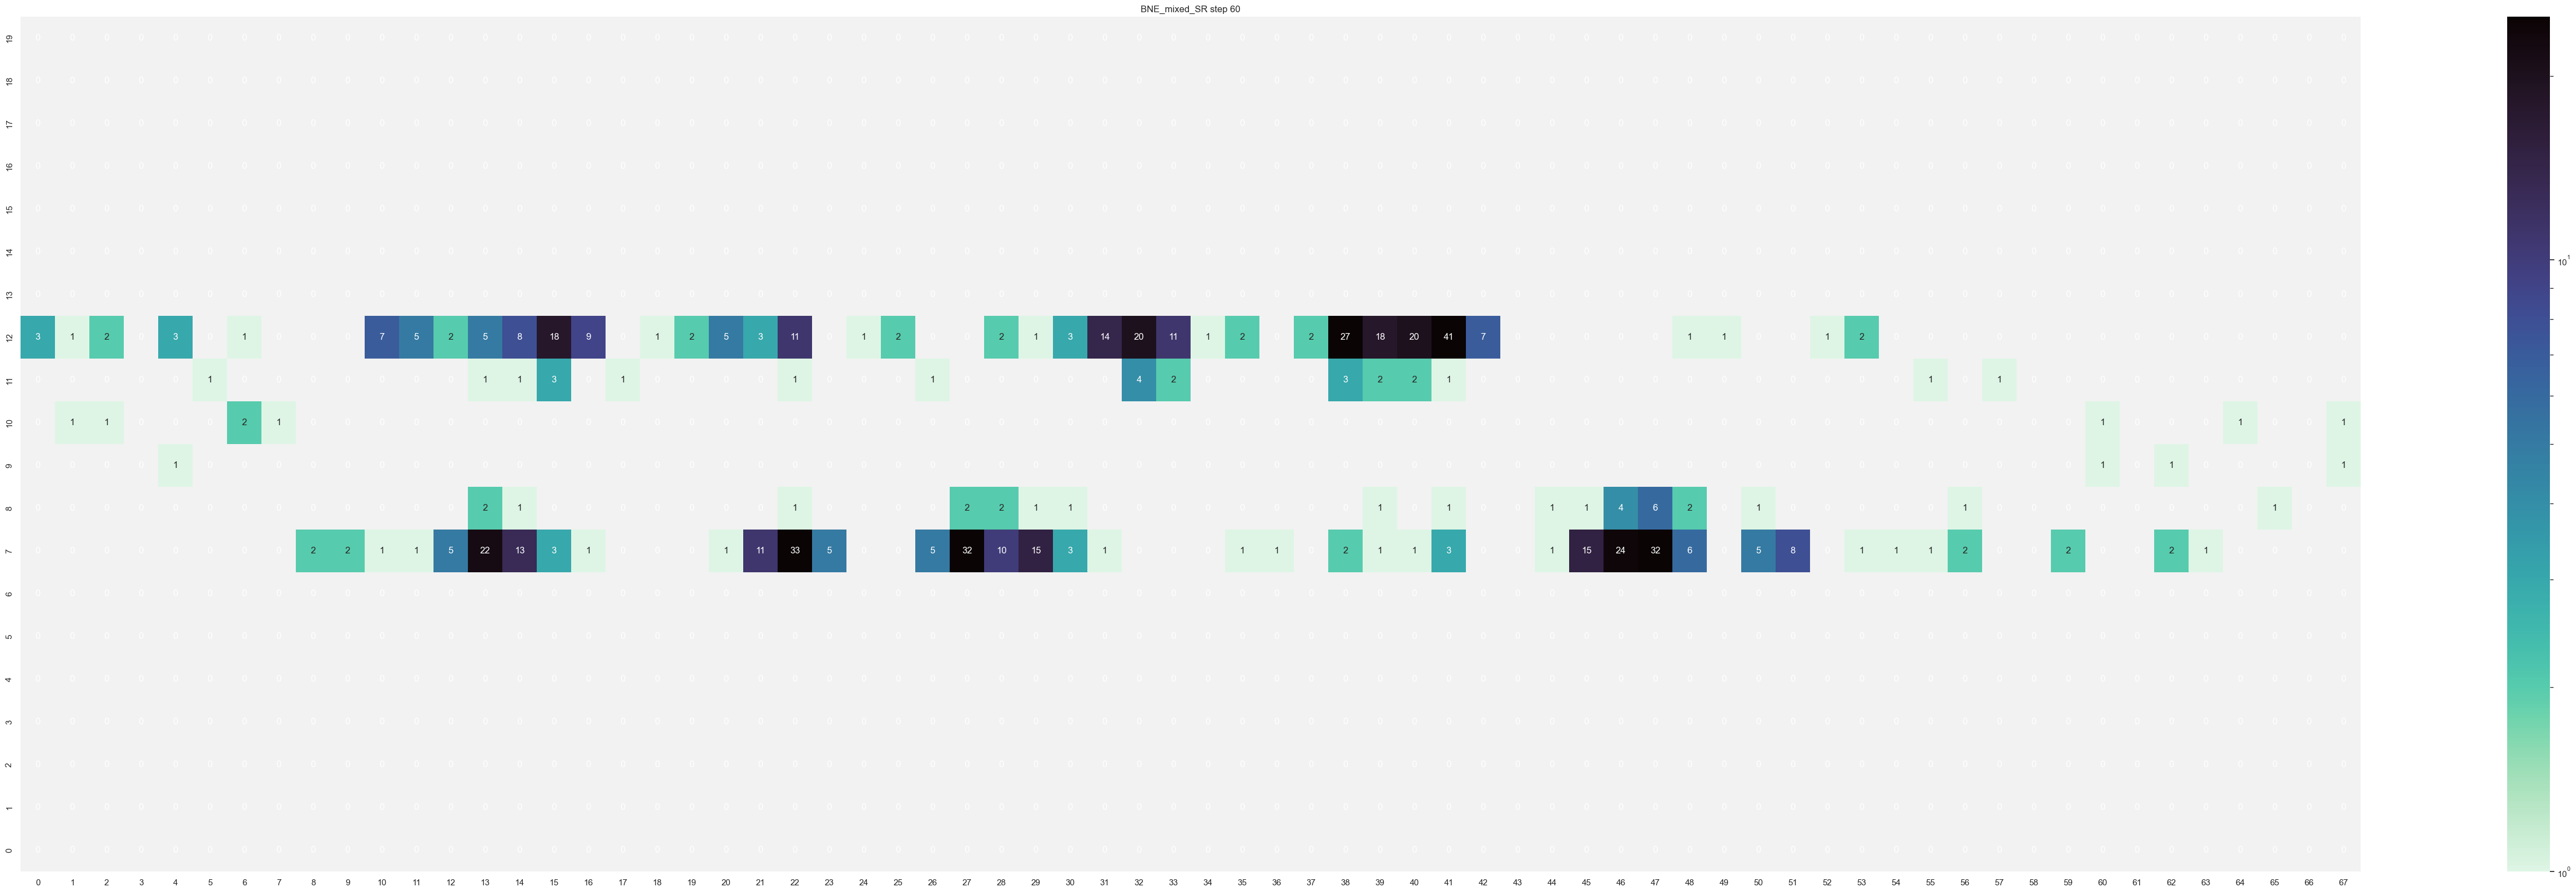

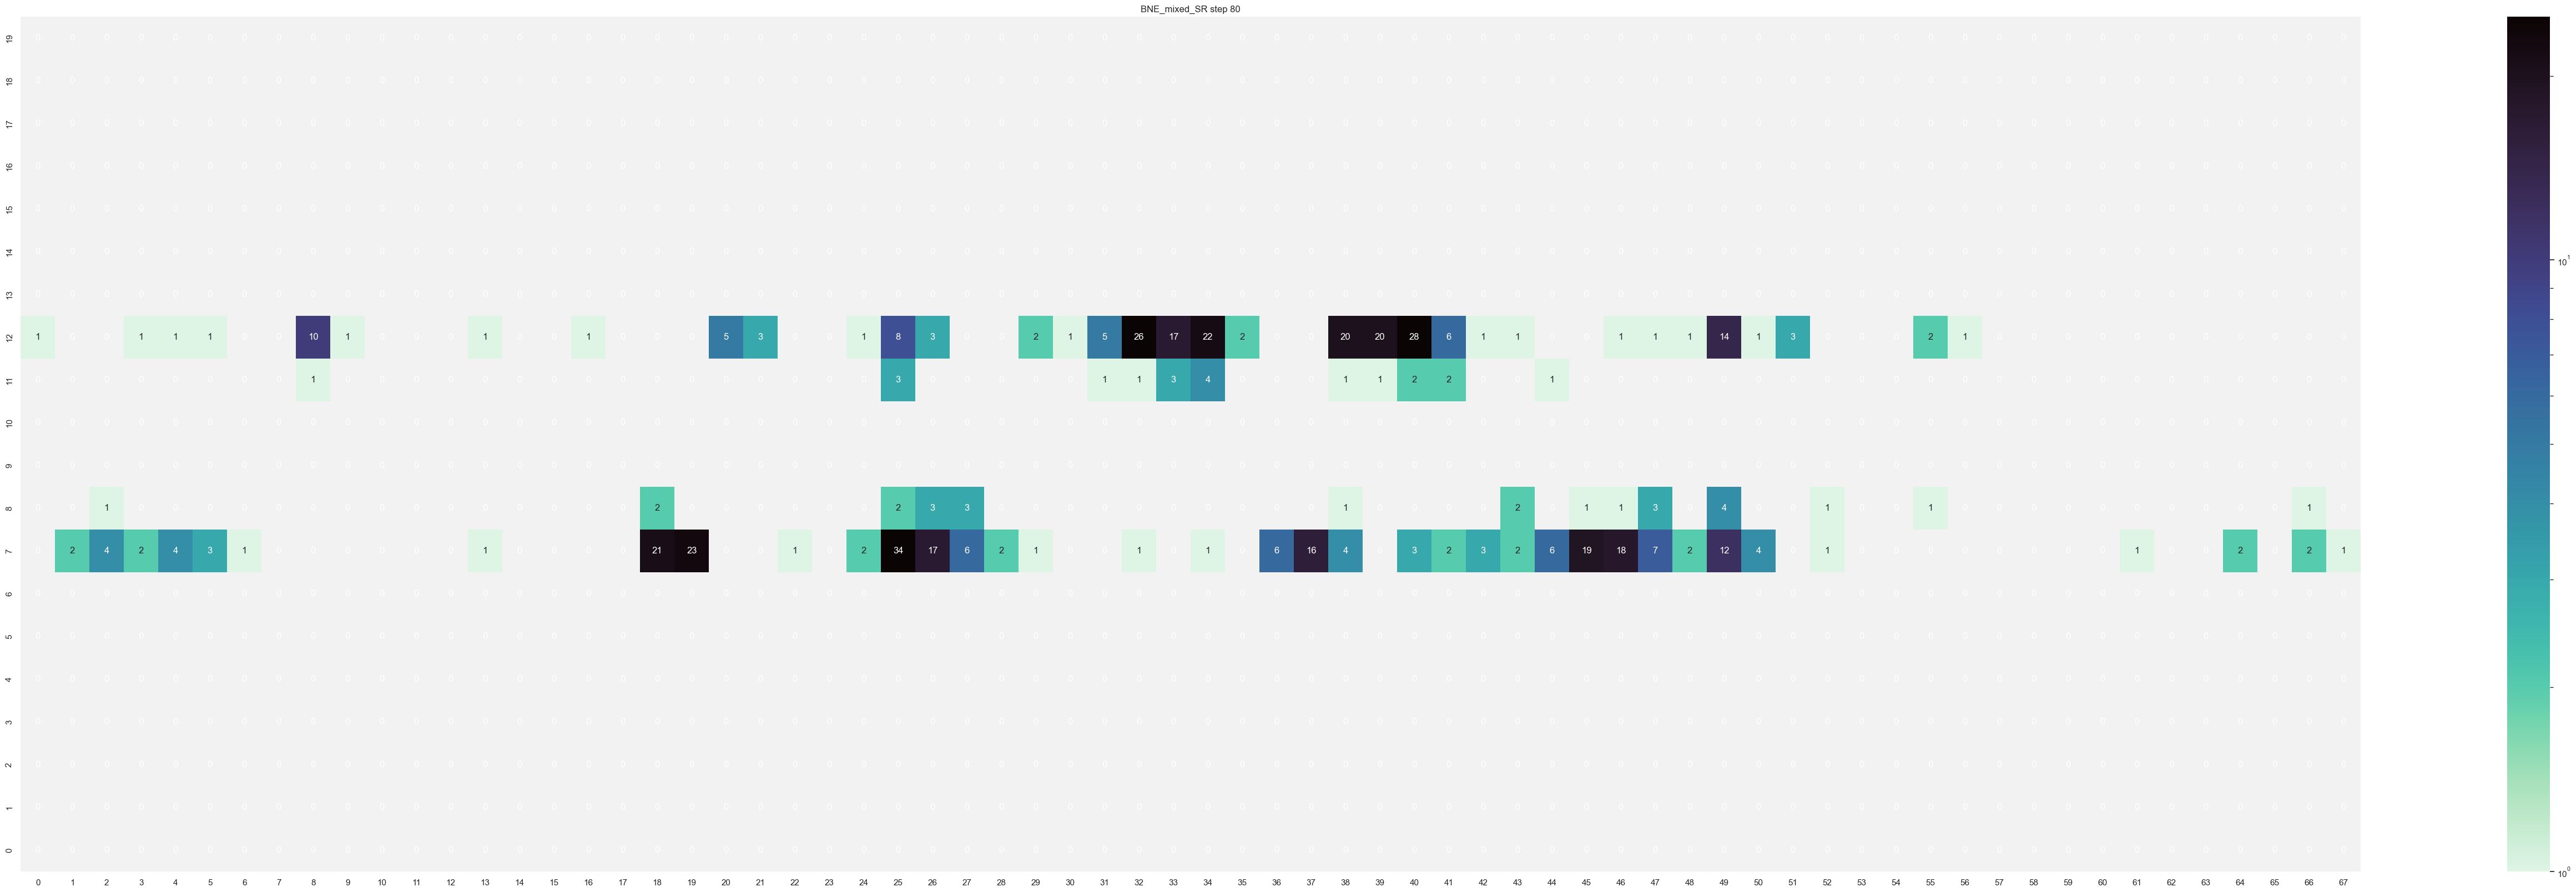

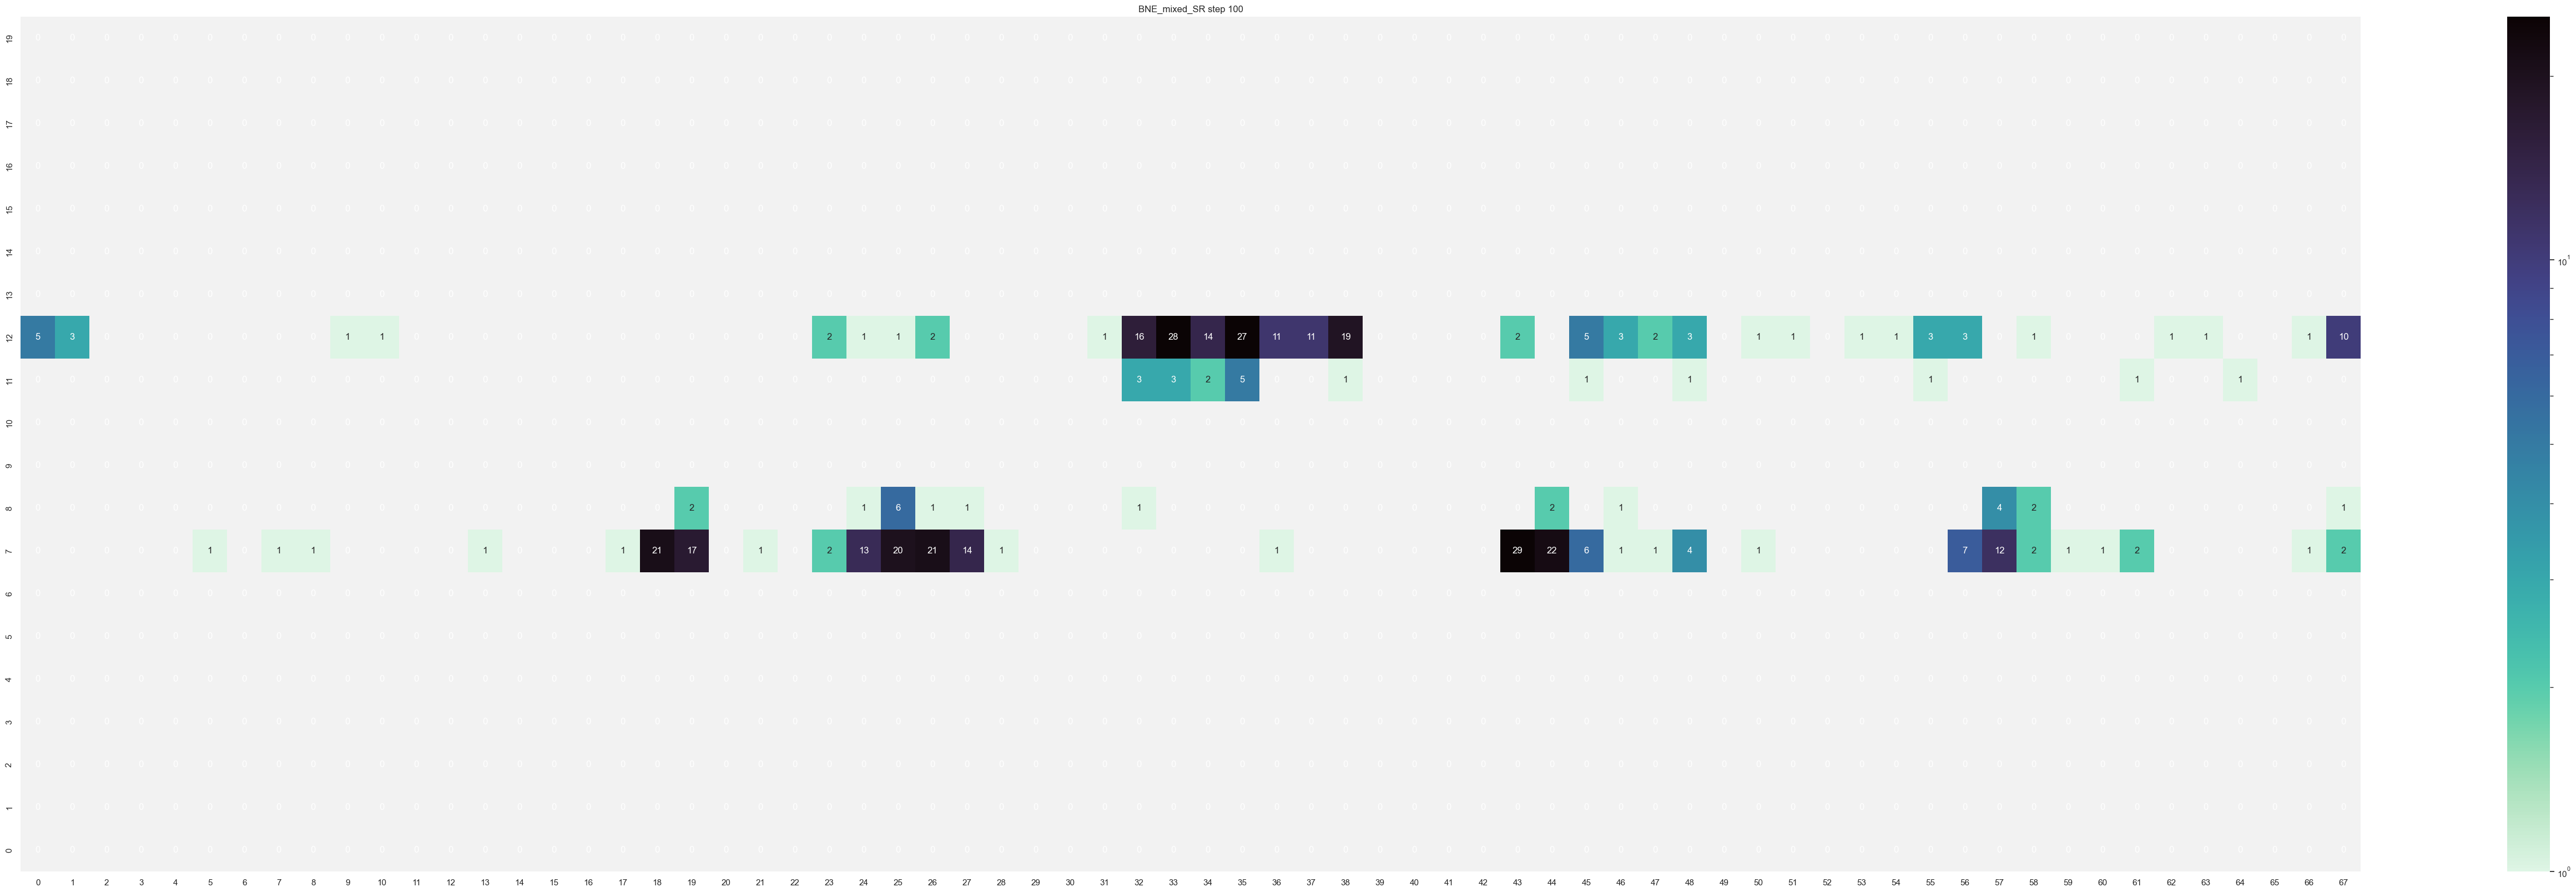

In [49]:
frames(("BNE_mixed_SR", 0))

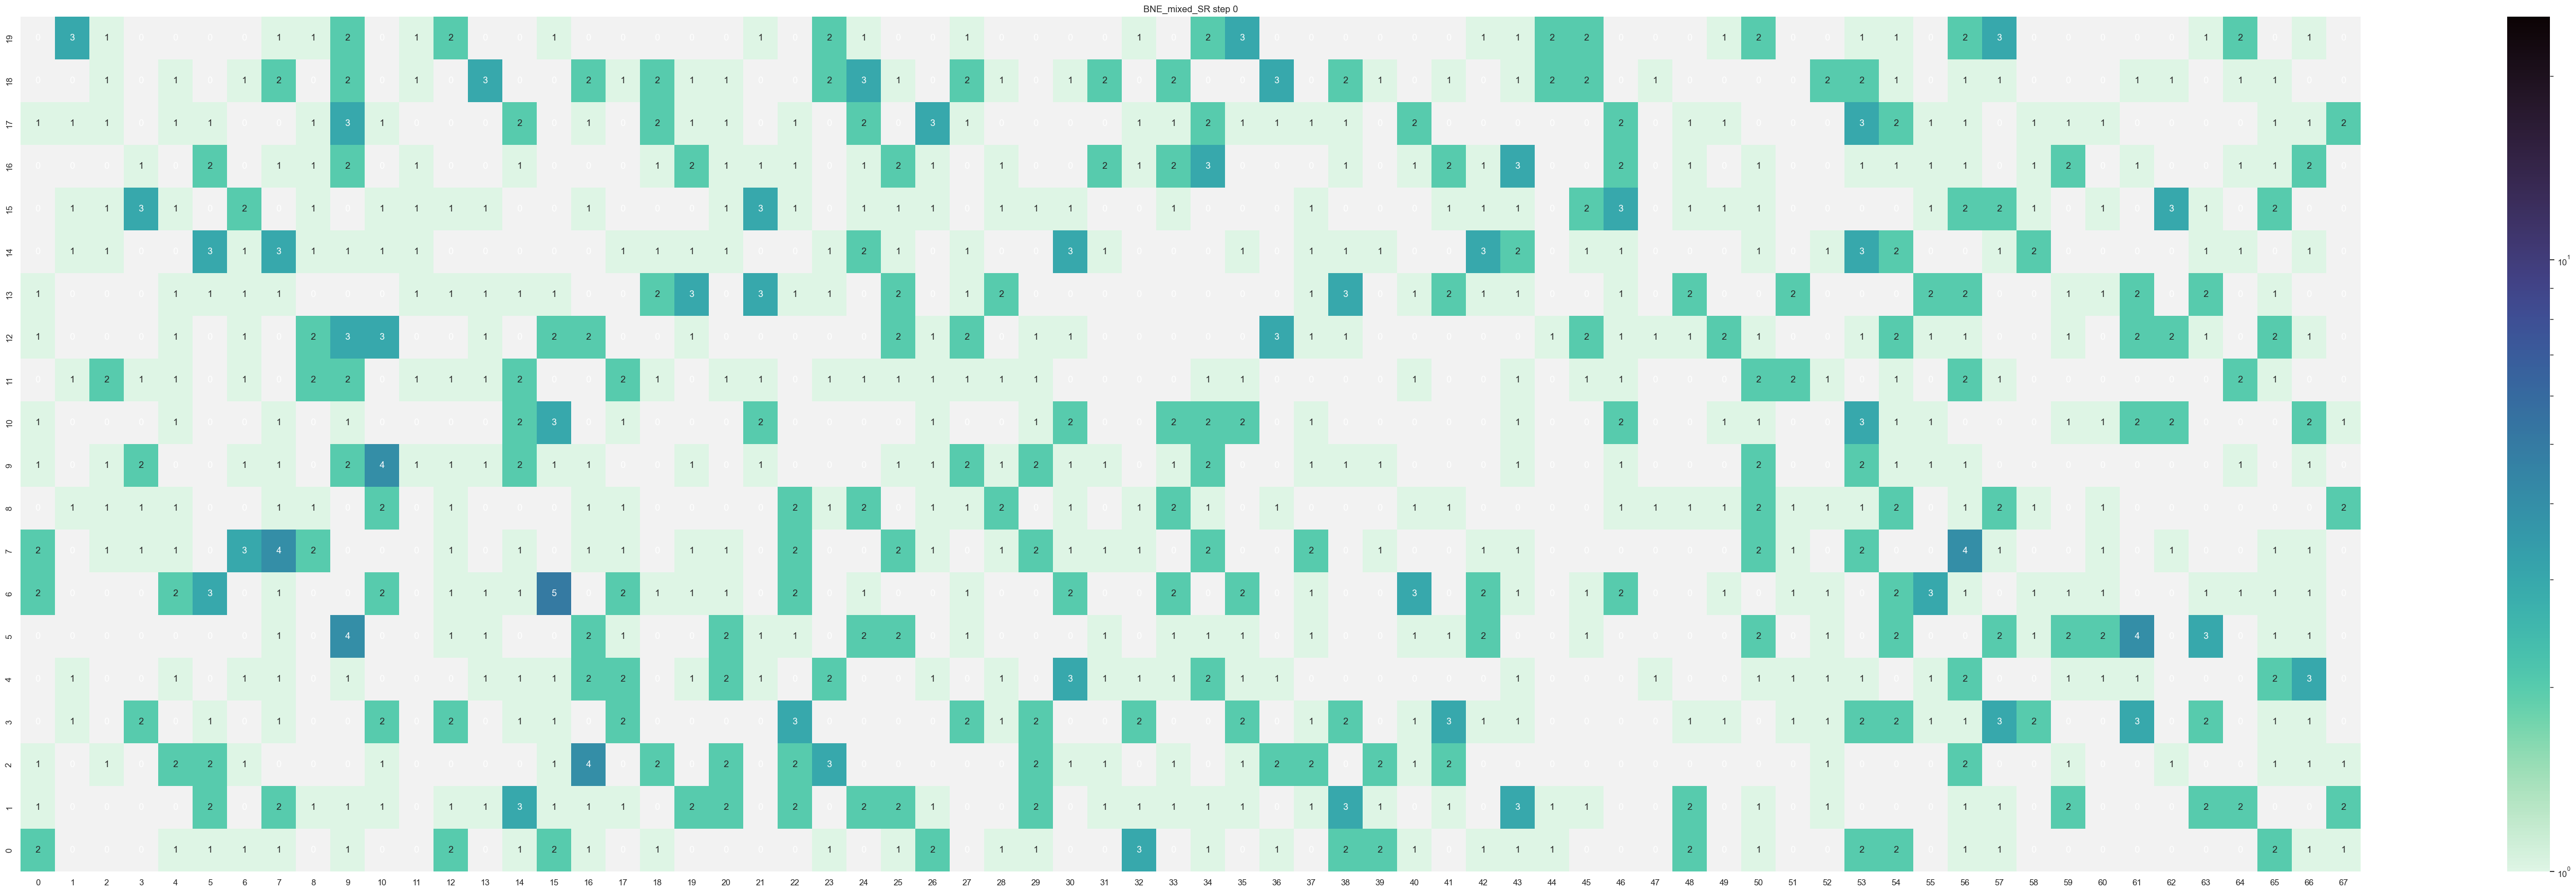

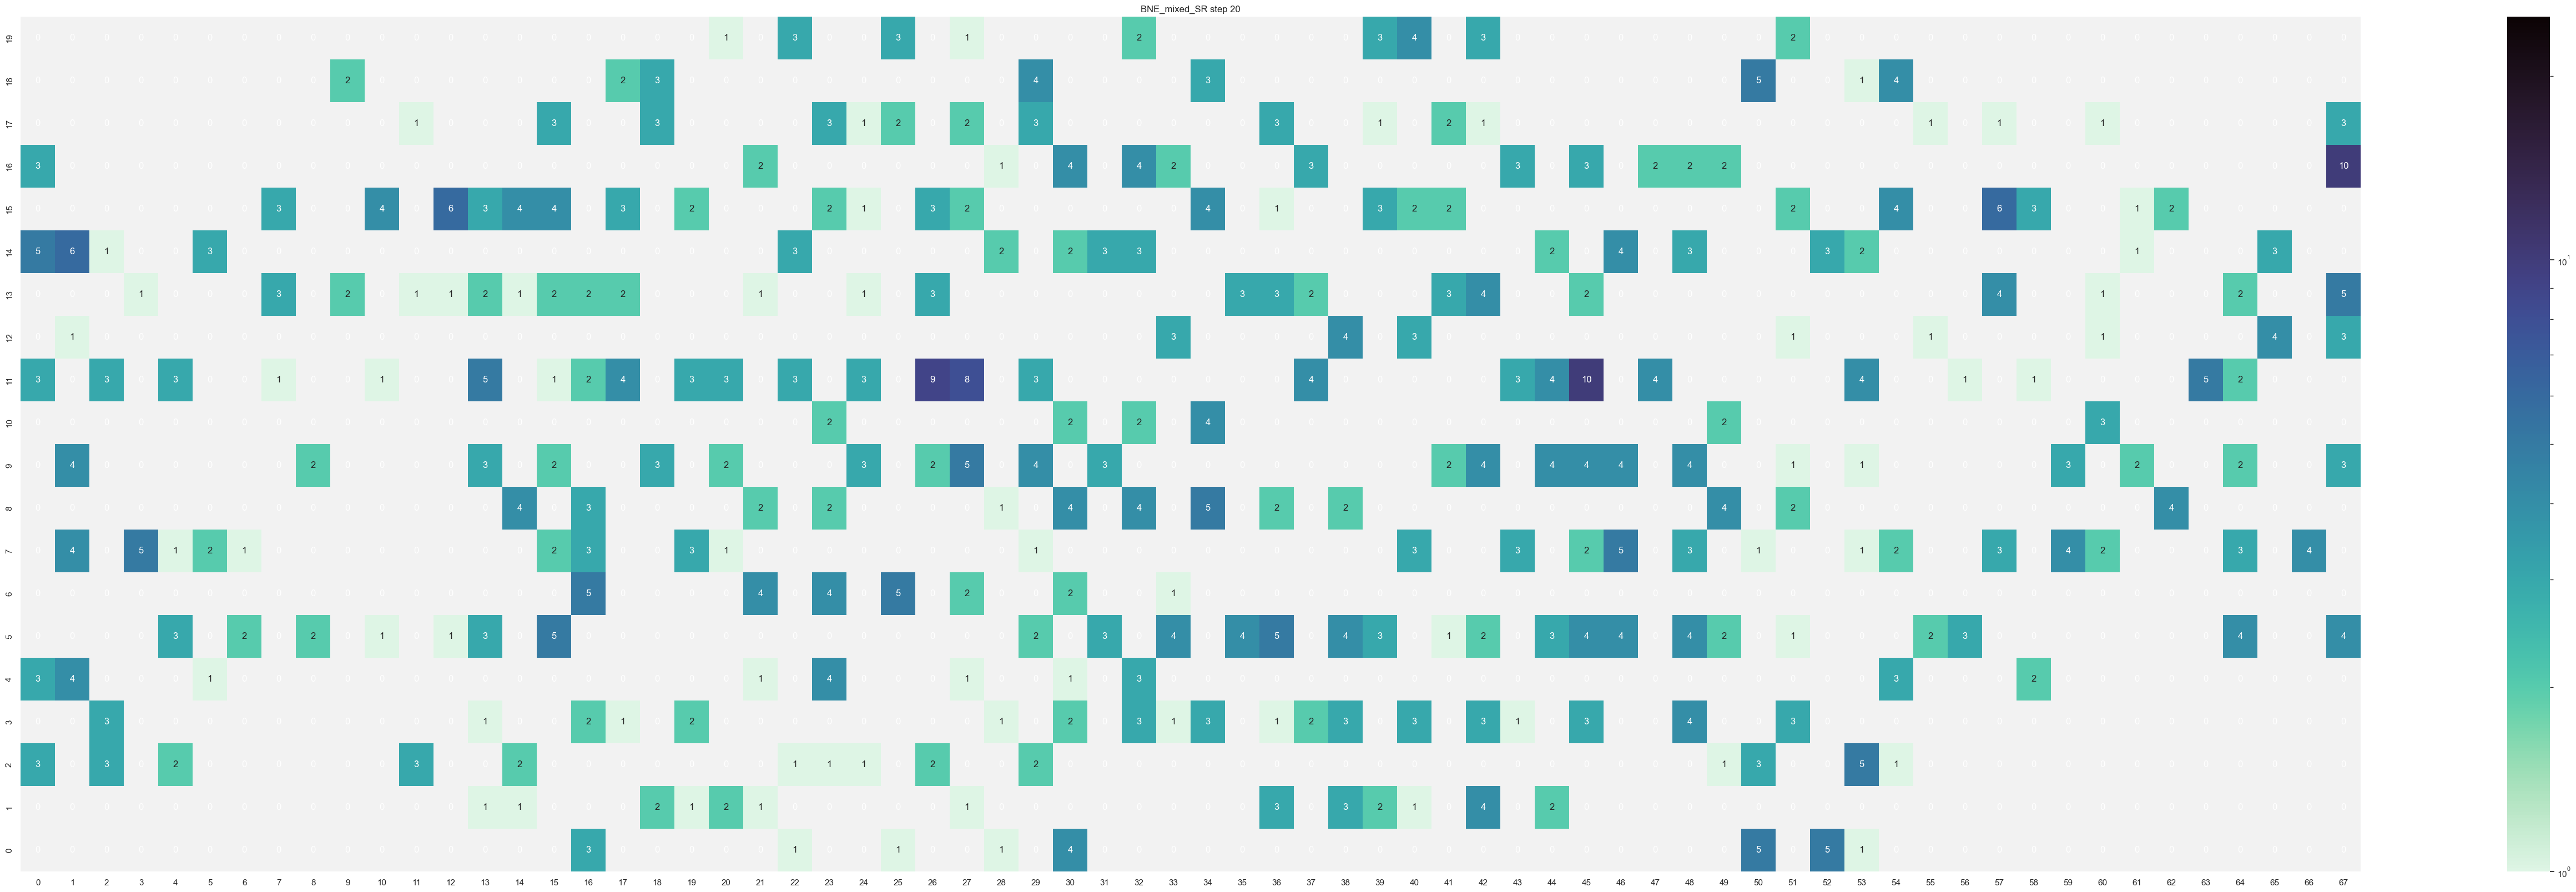

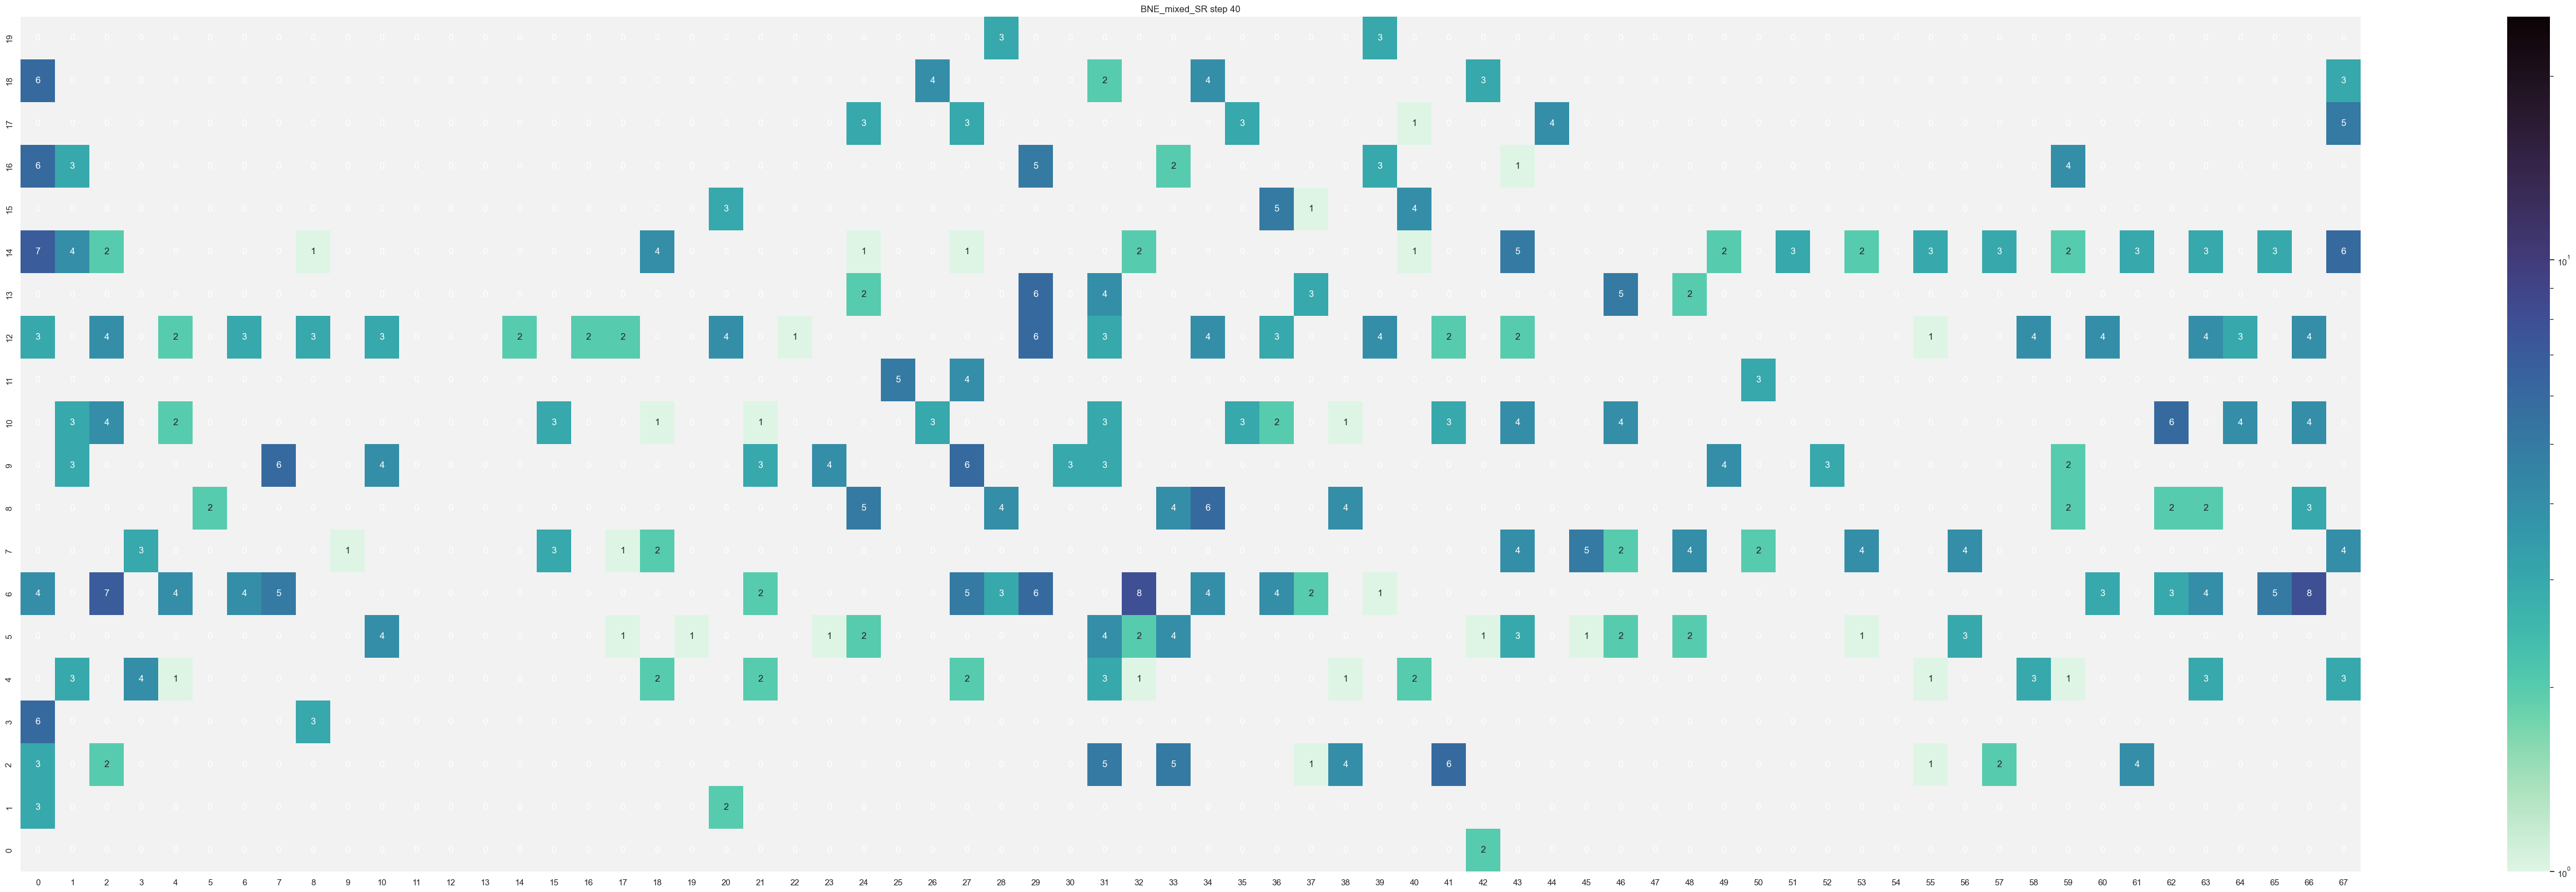

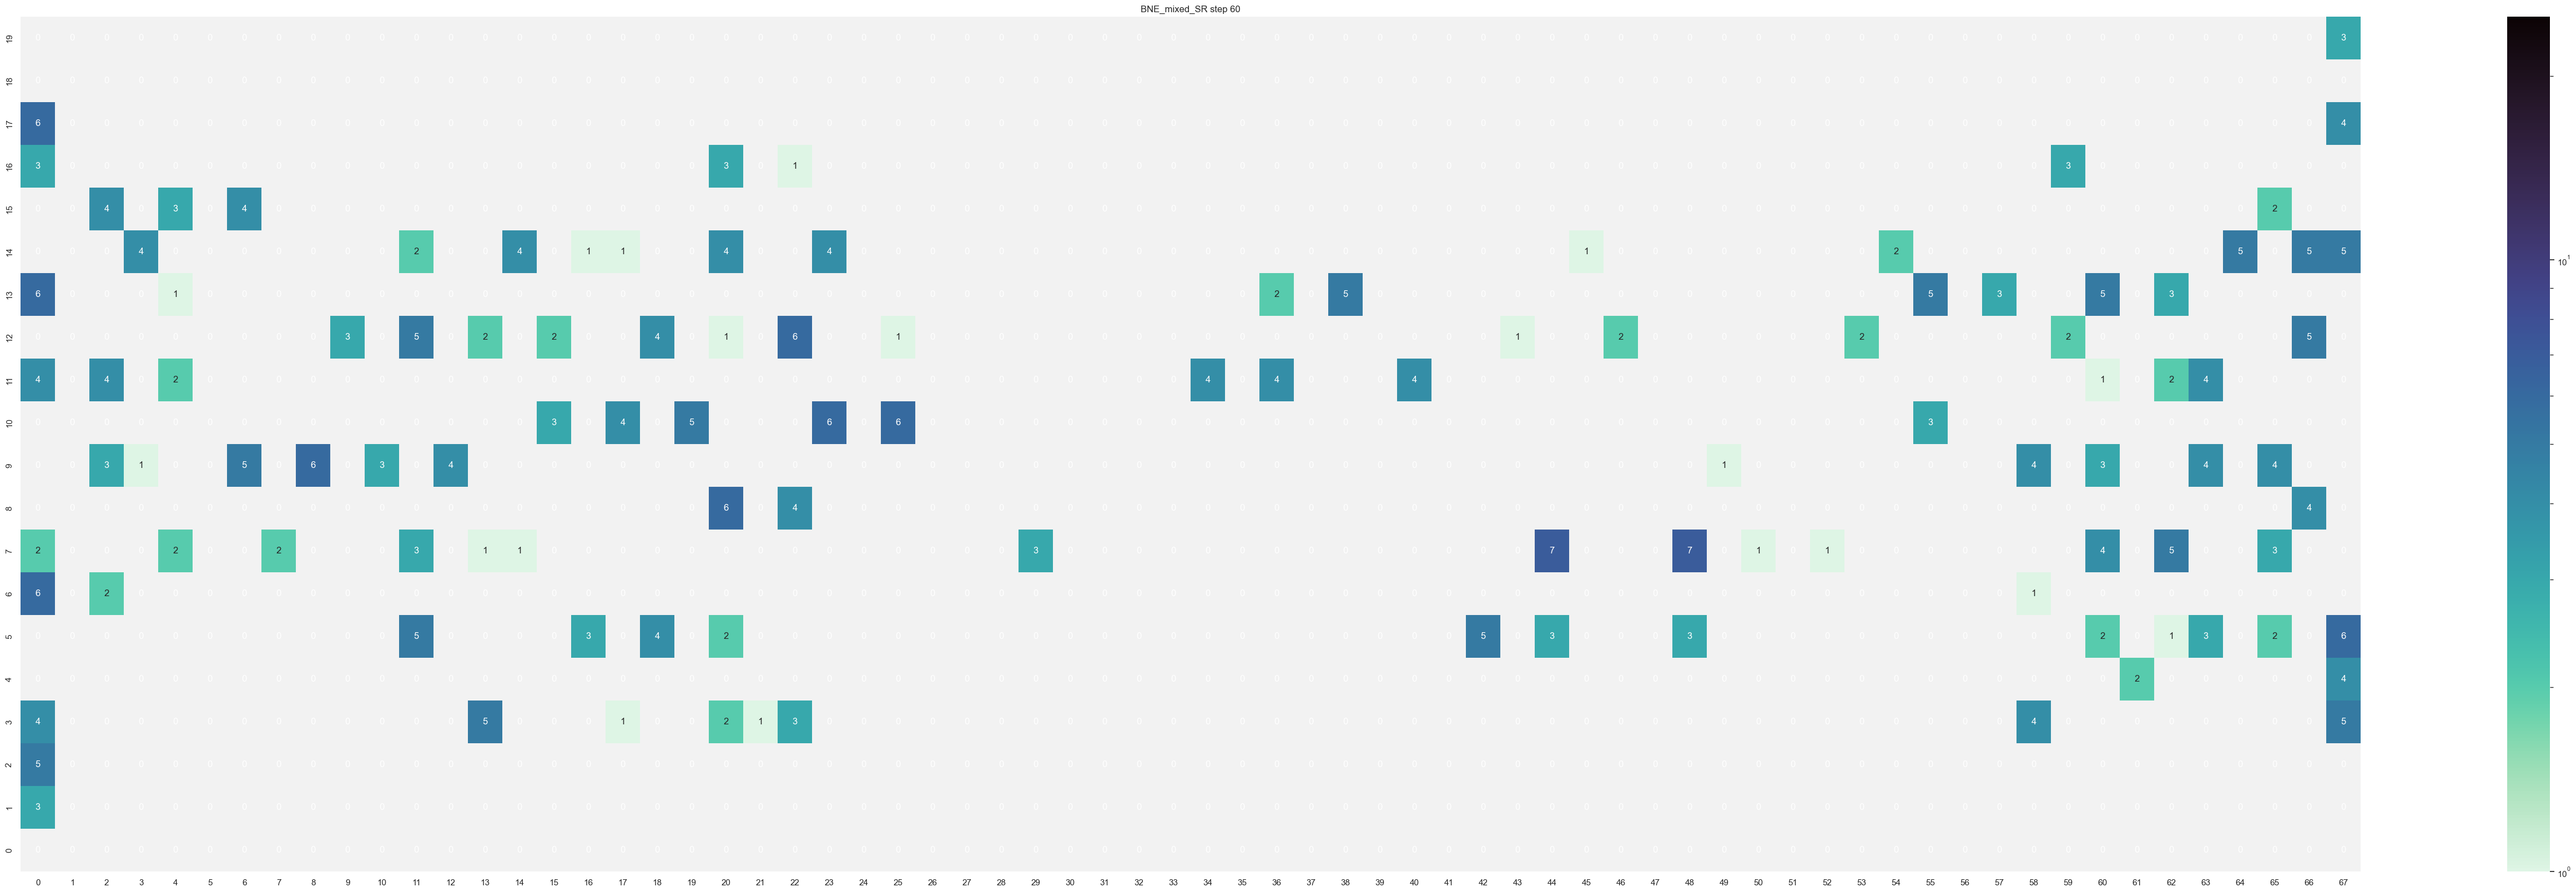

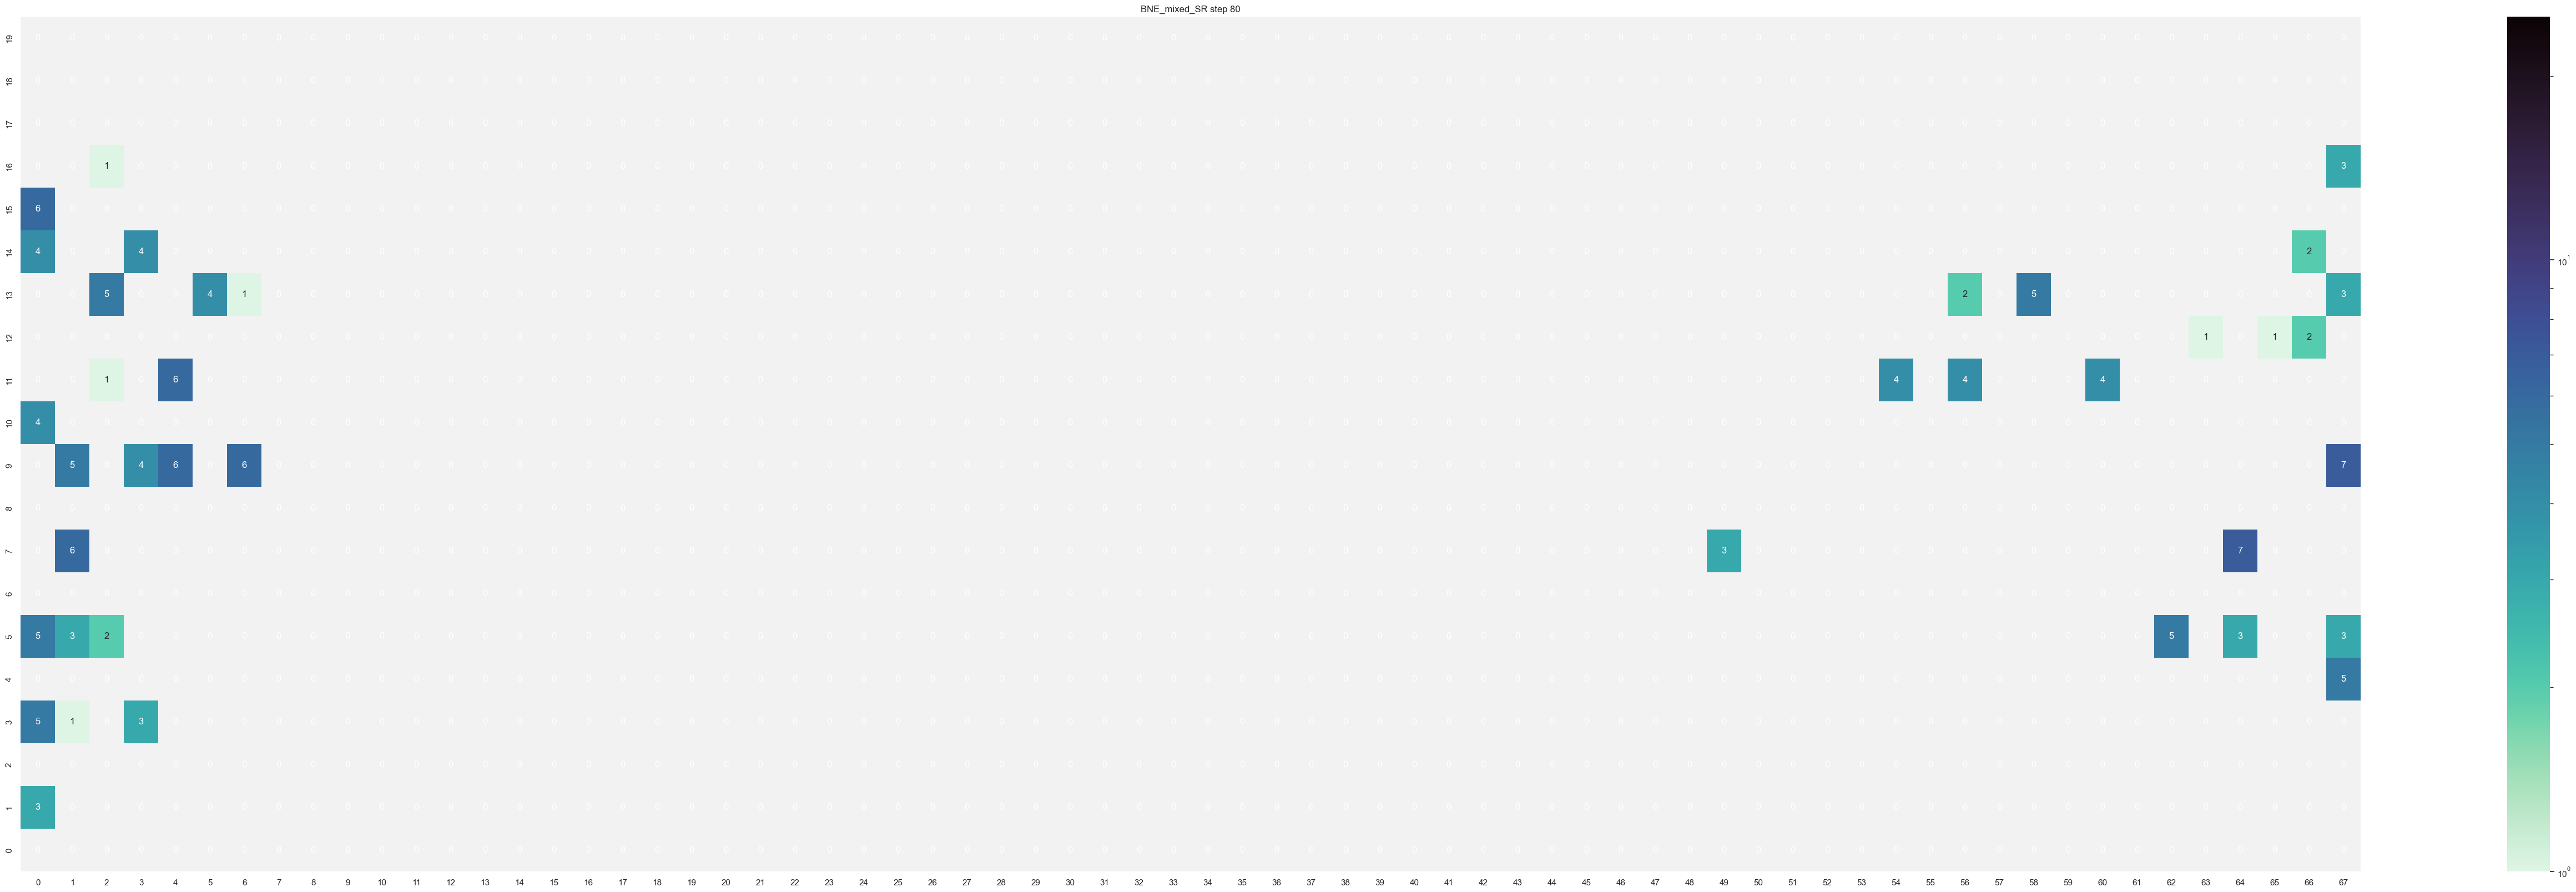

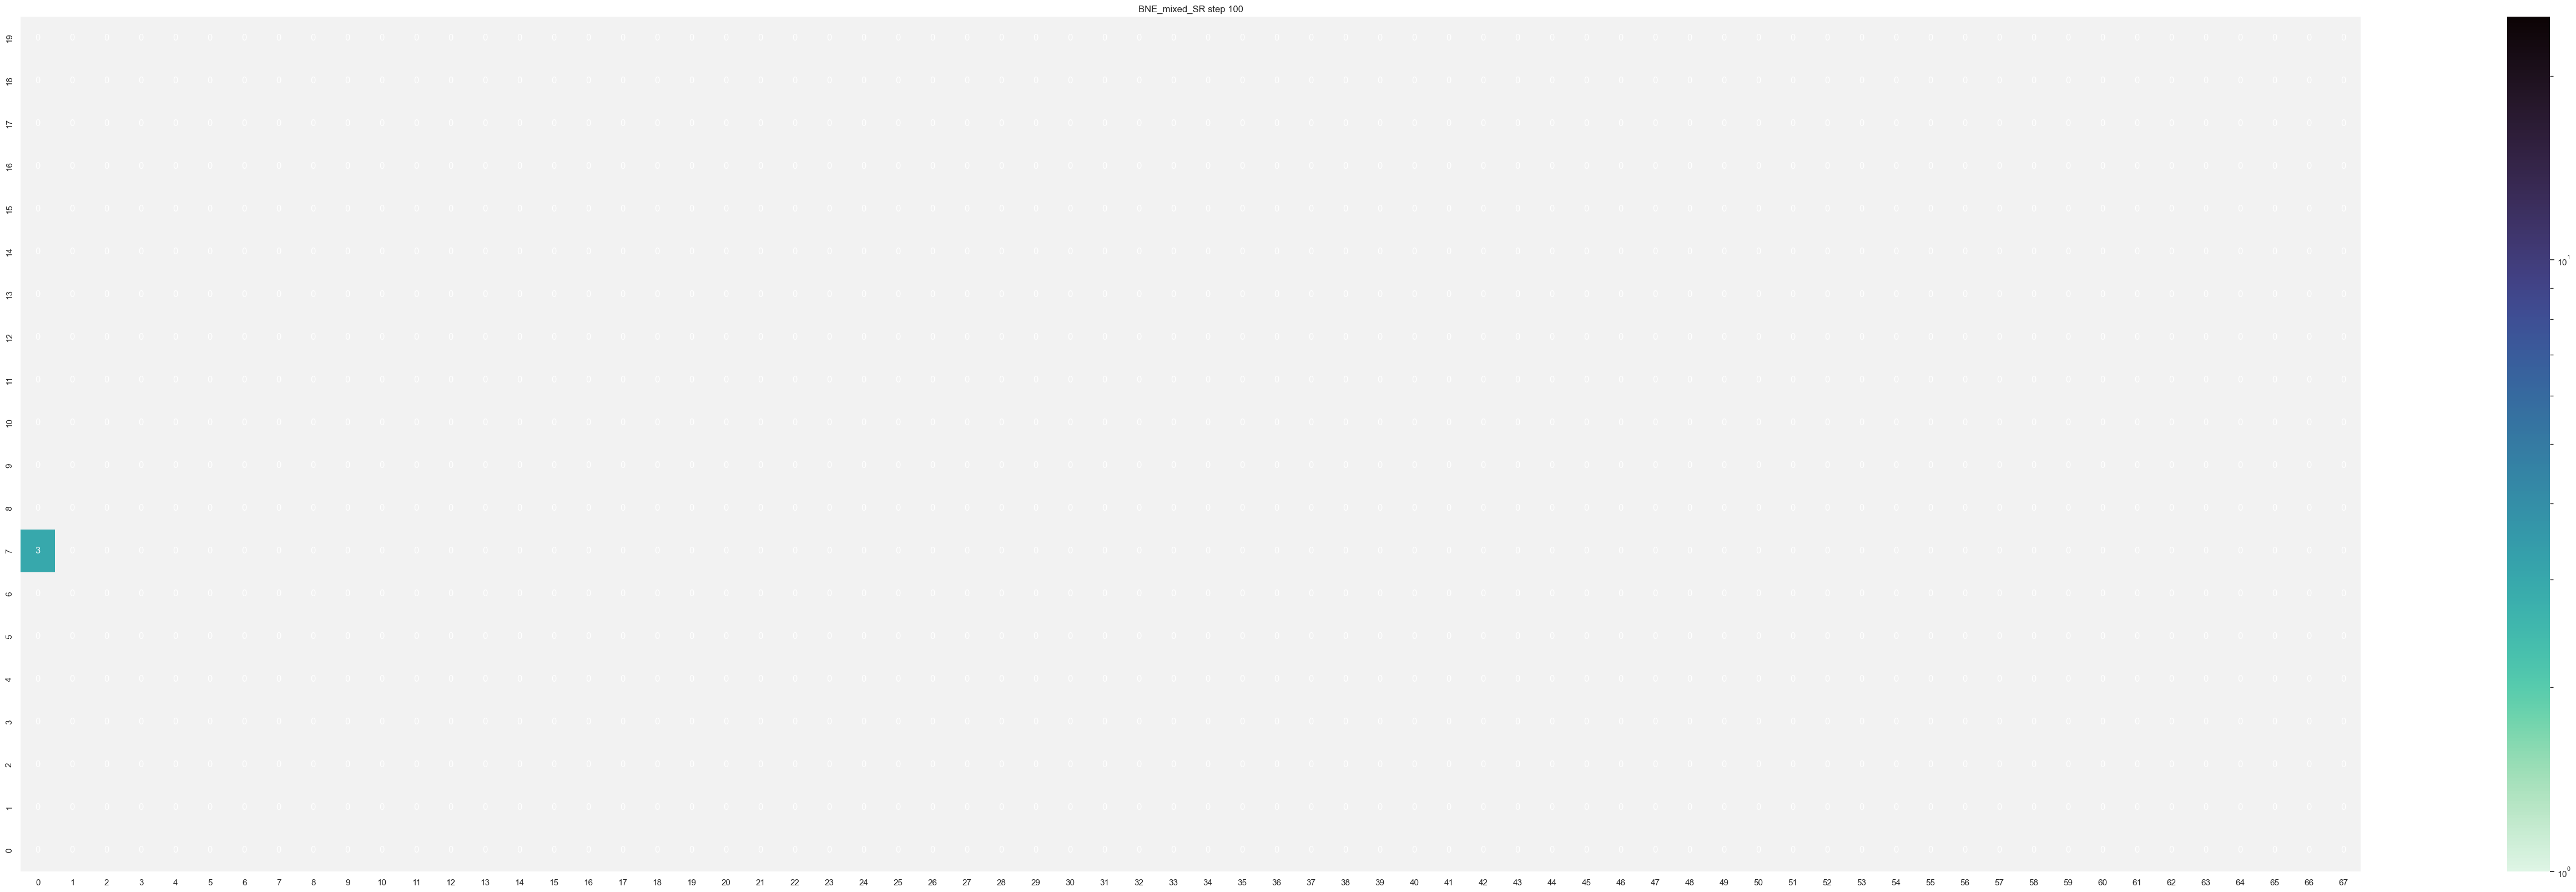

In [51]:
frames(("BNE_mixed_SR", 100))

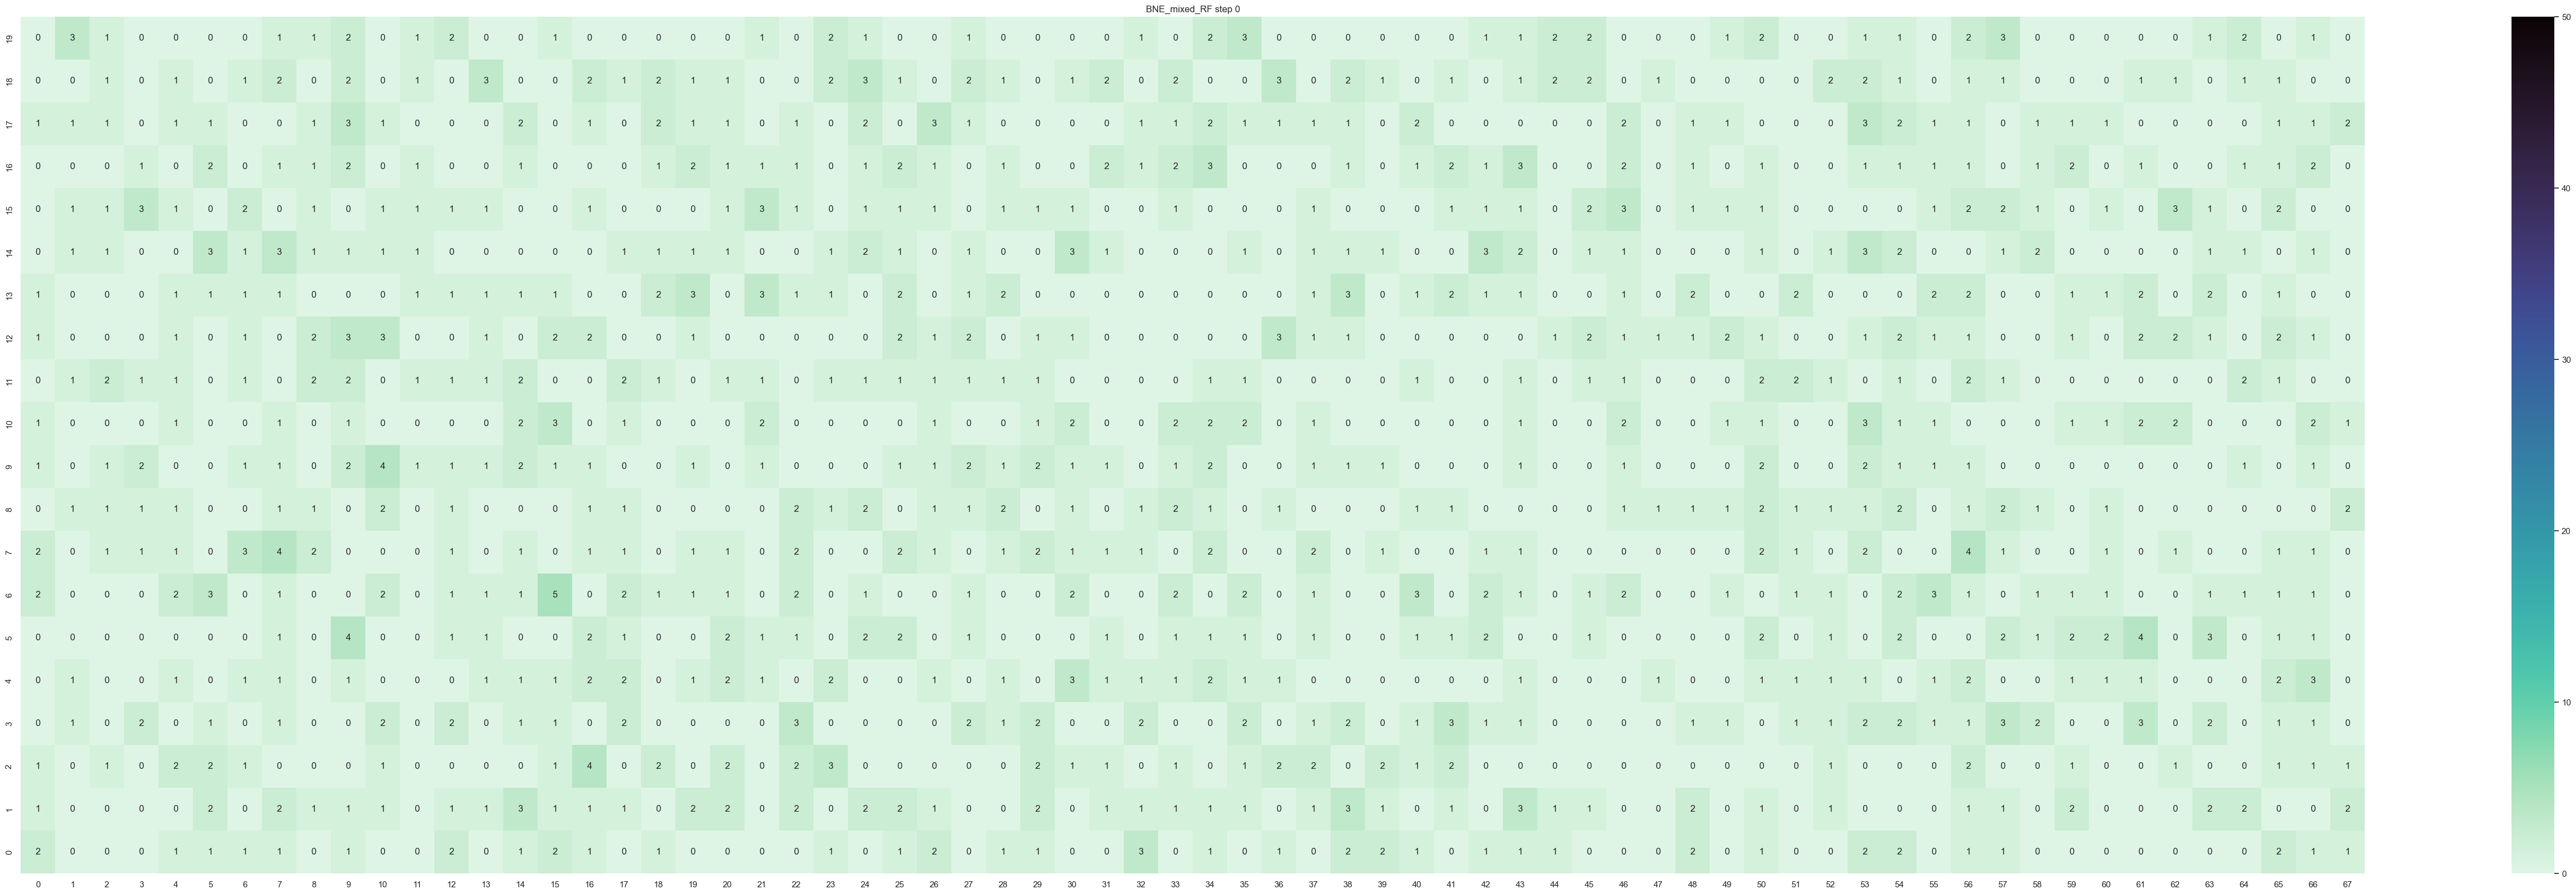

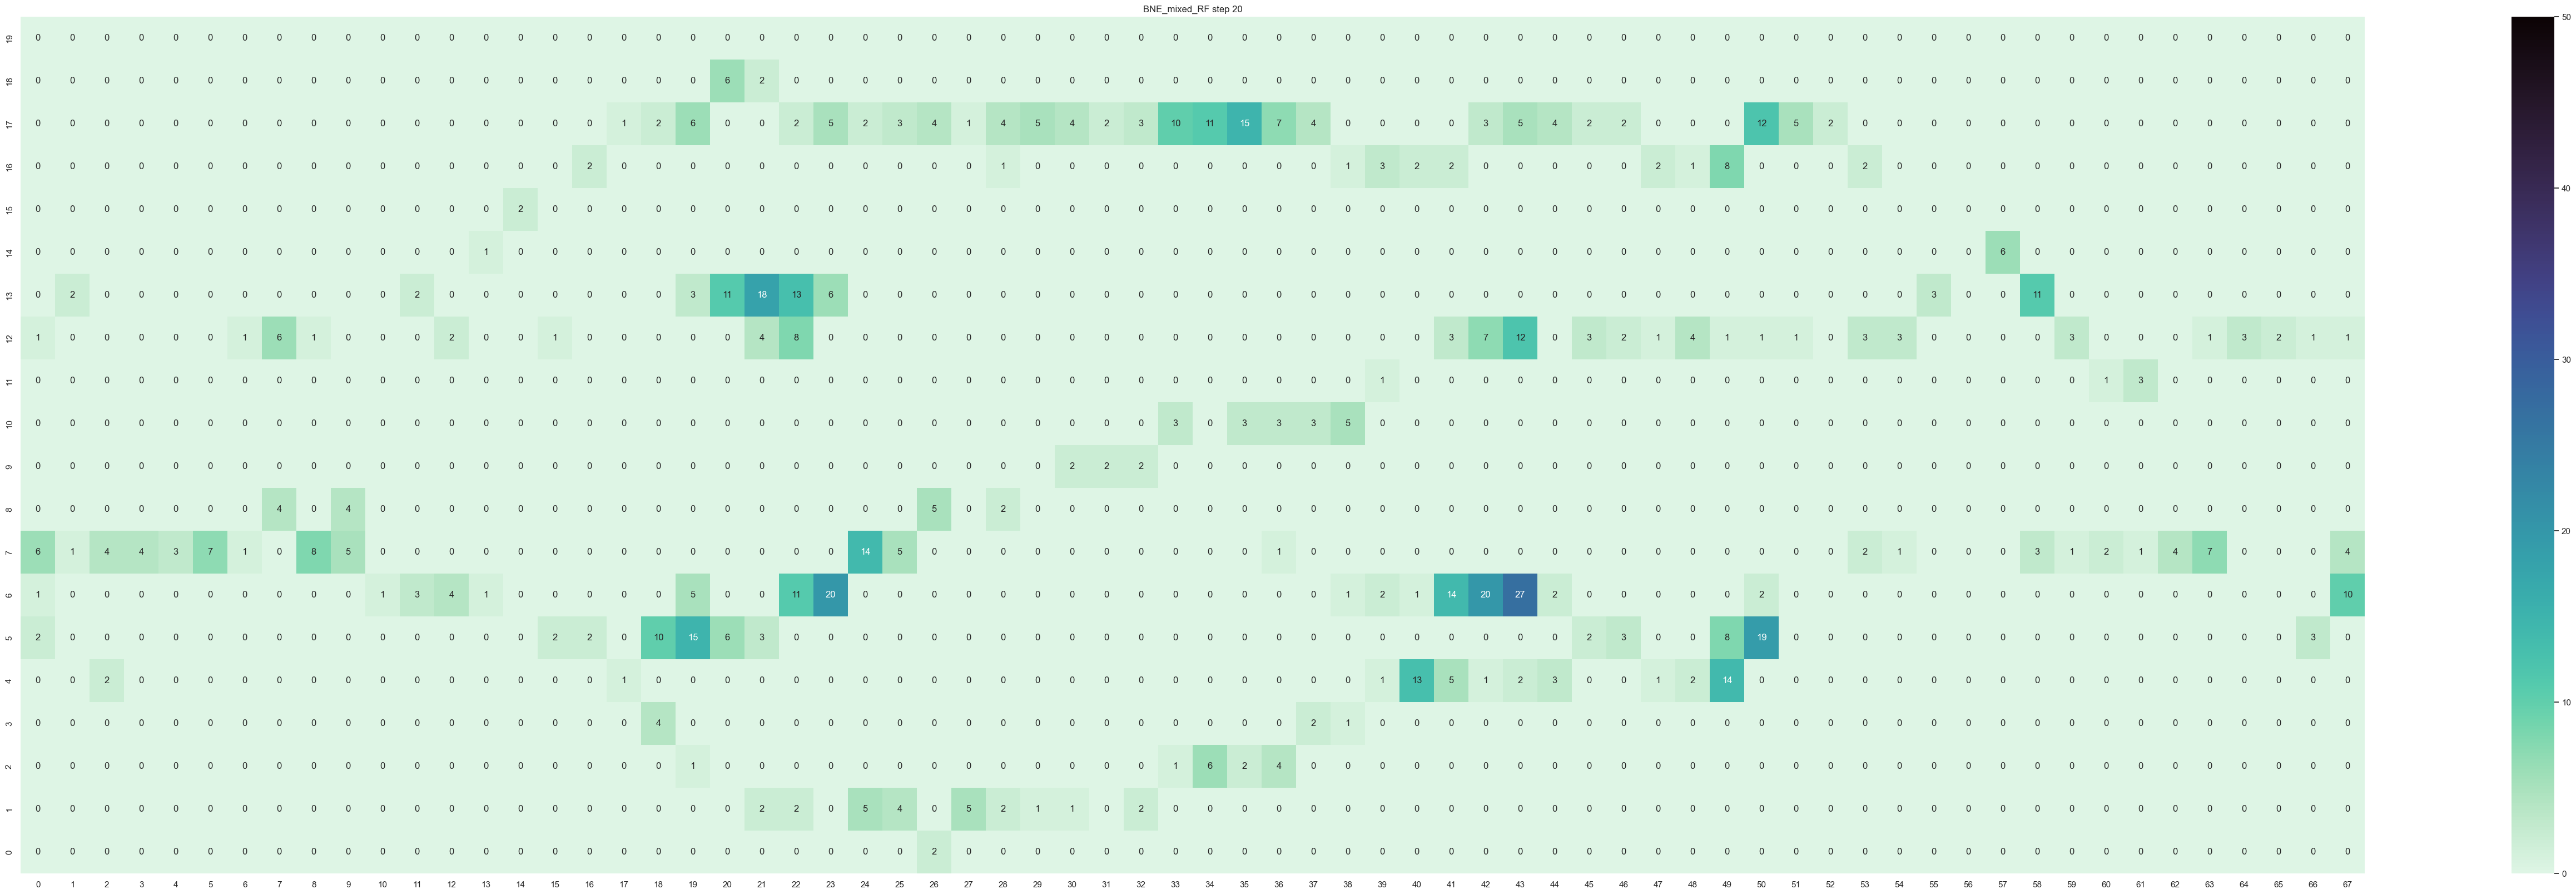

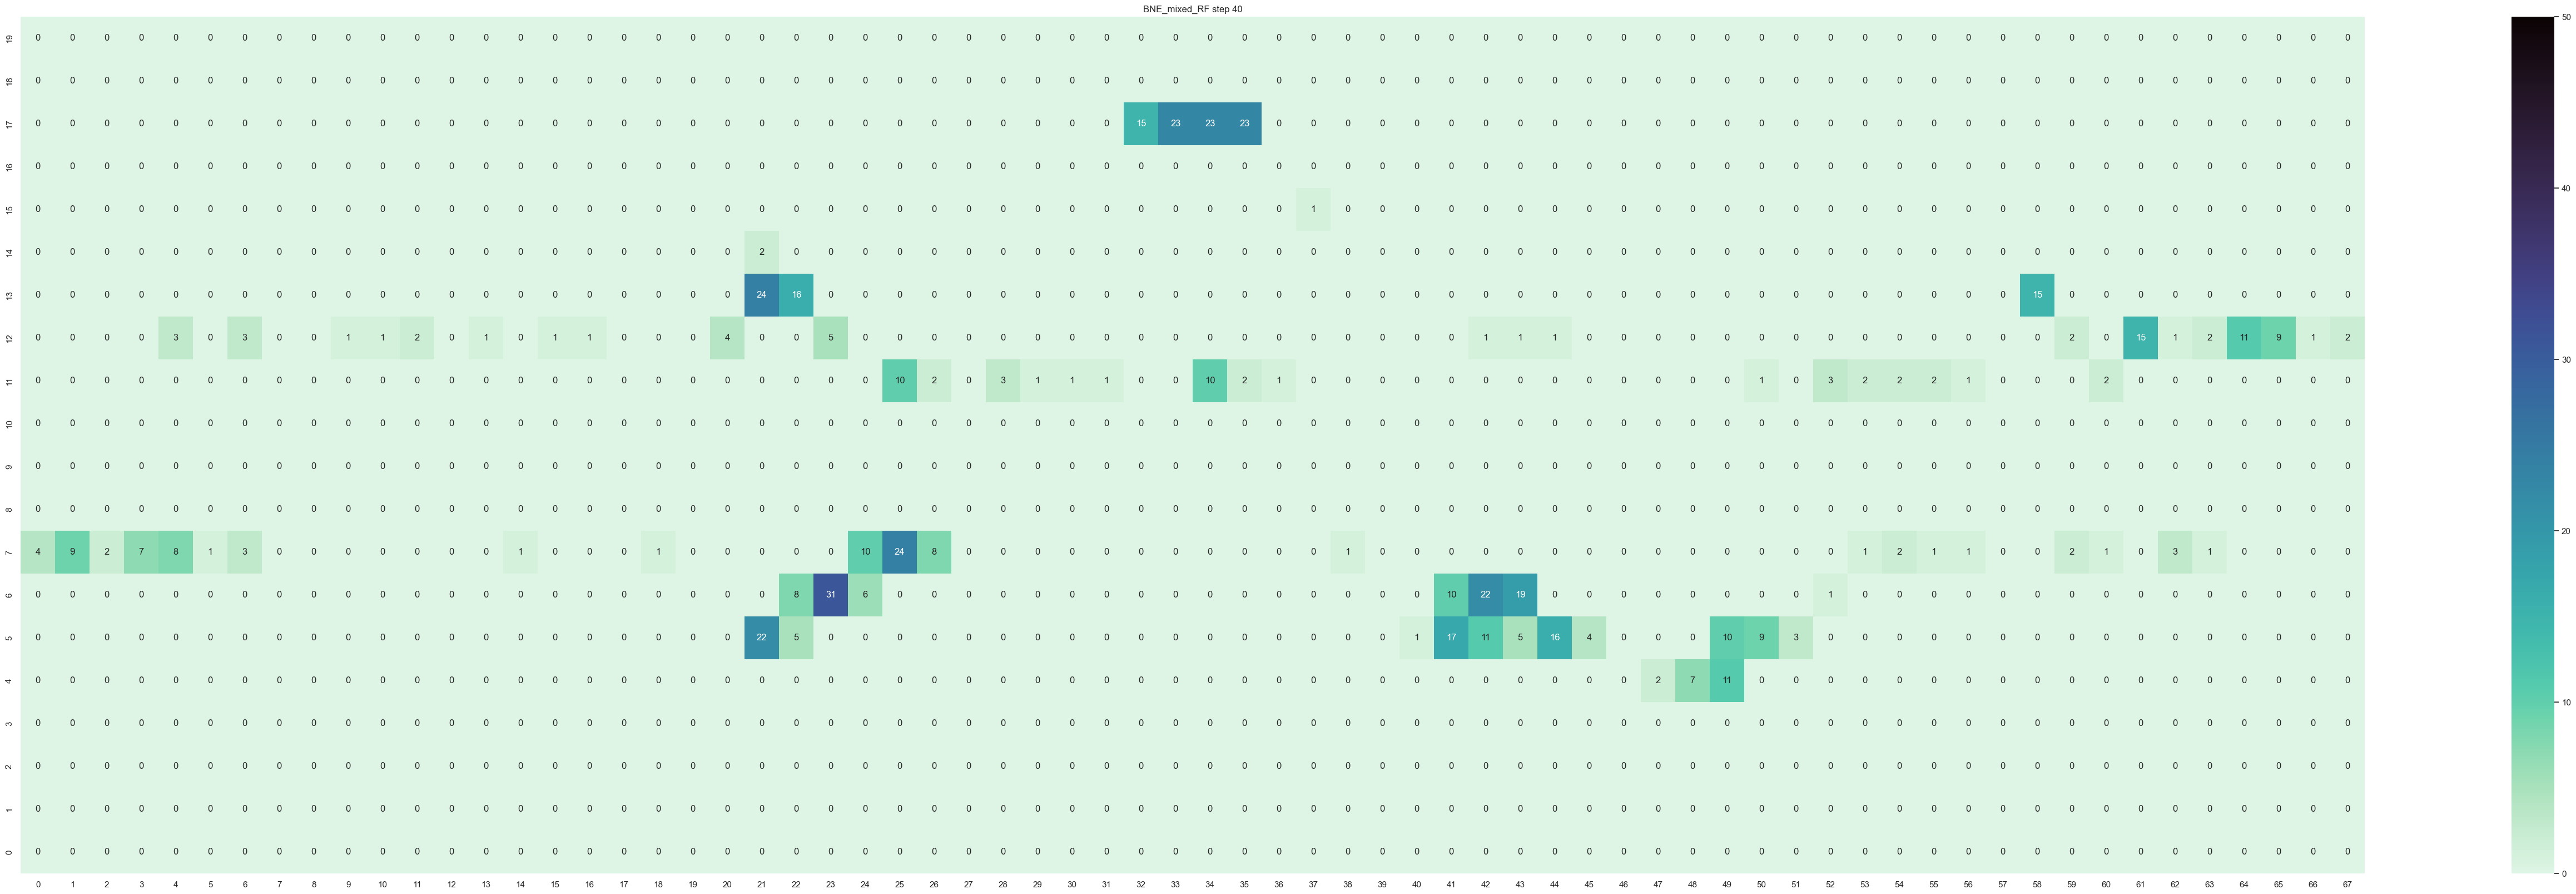

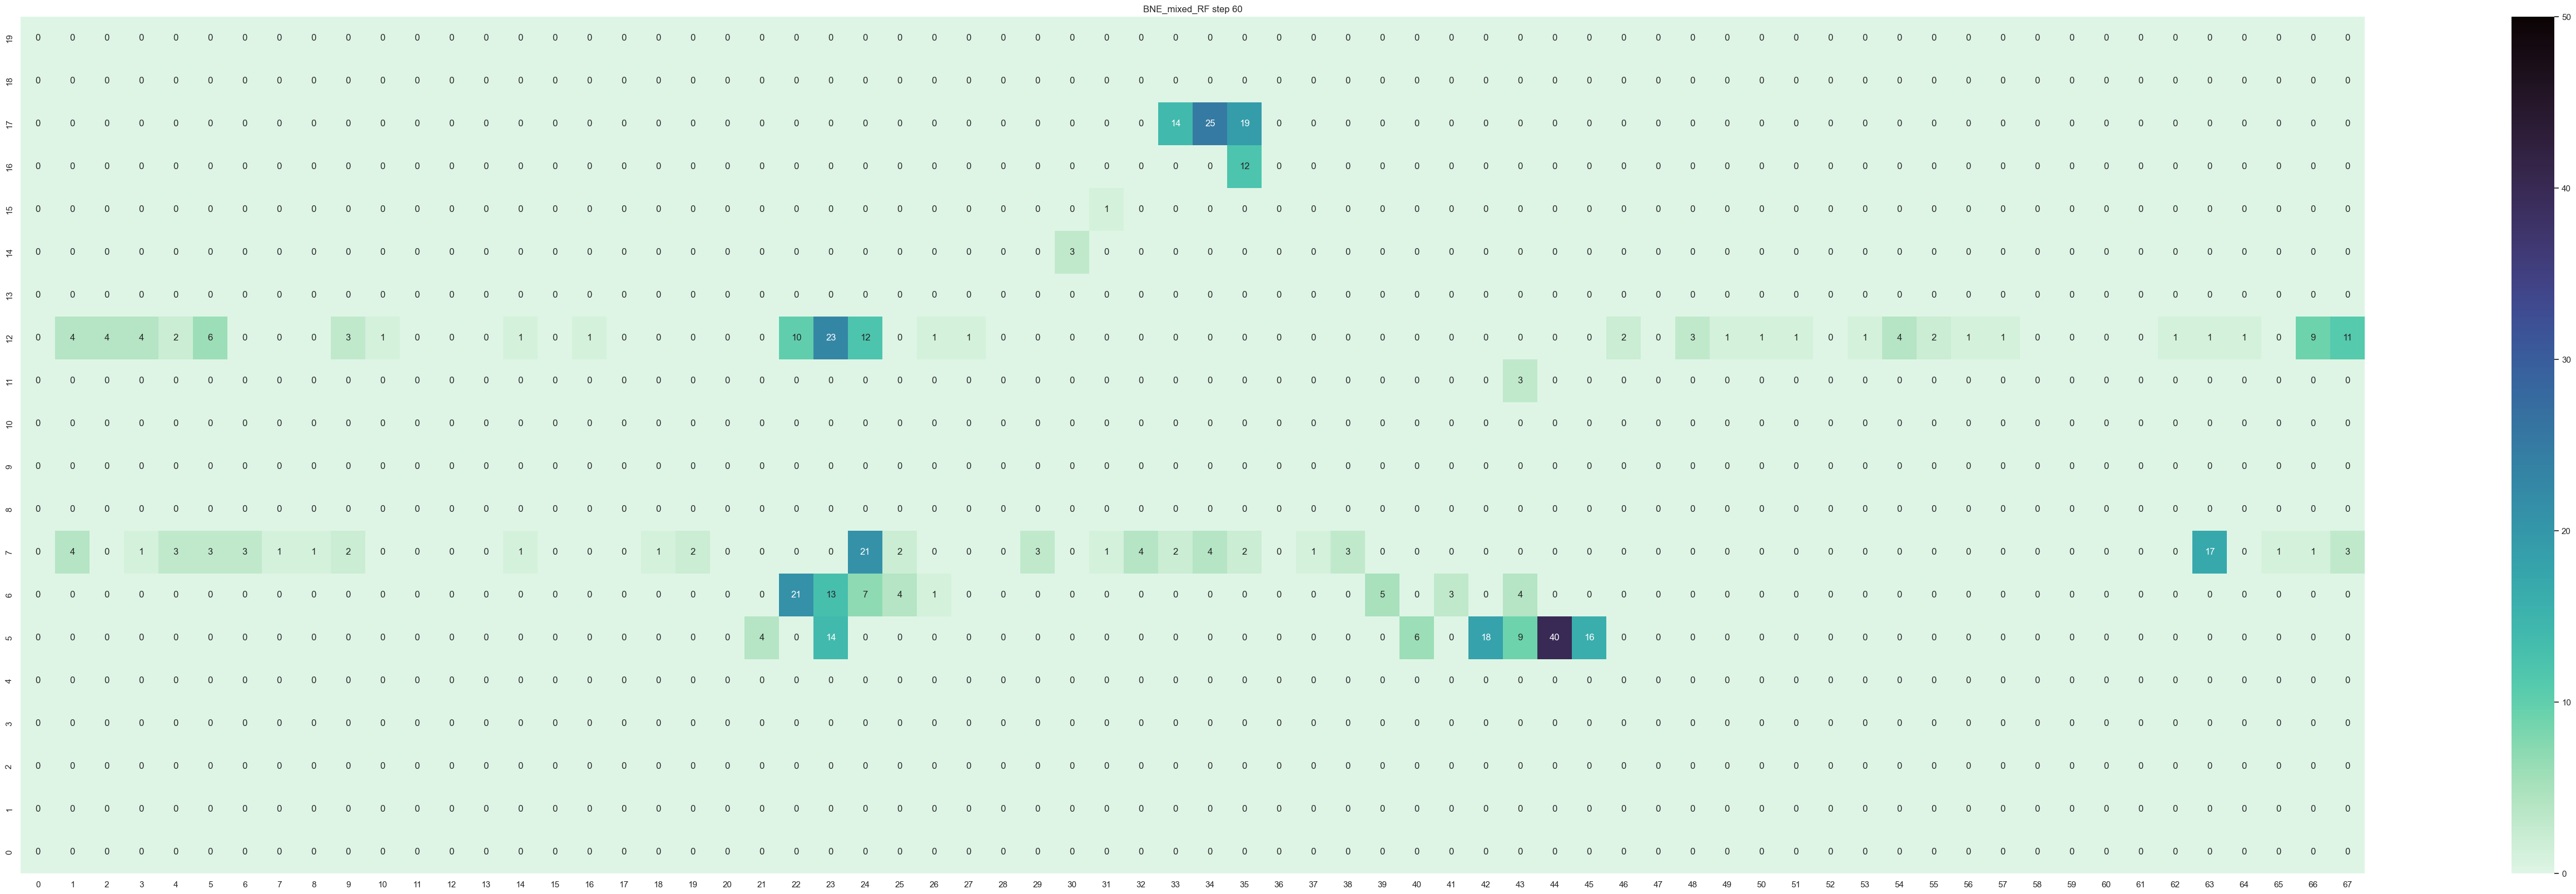

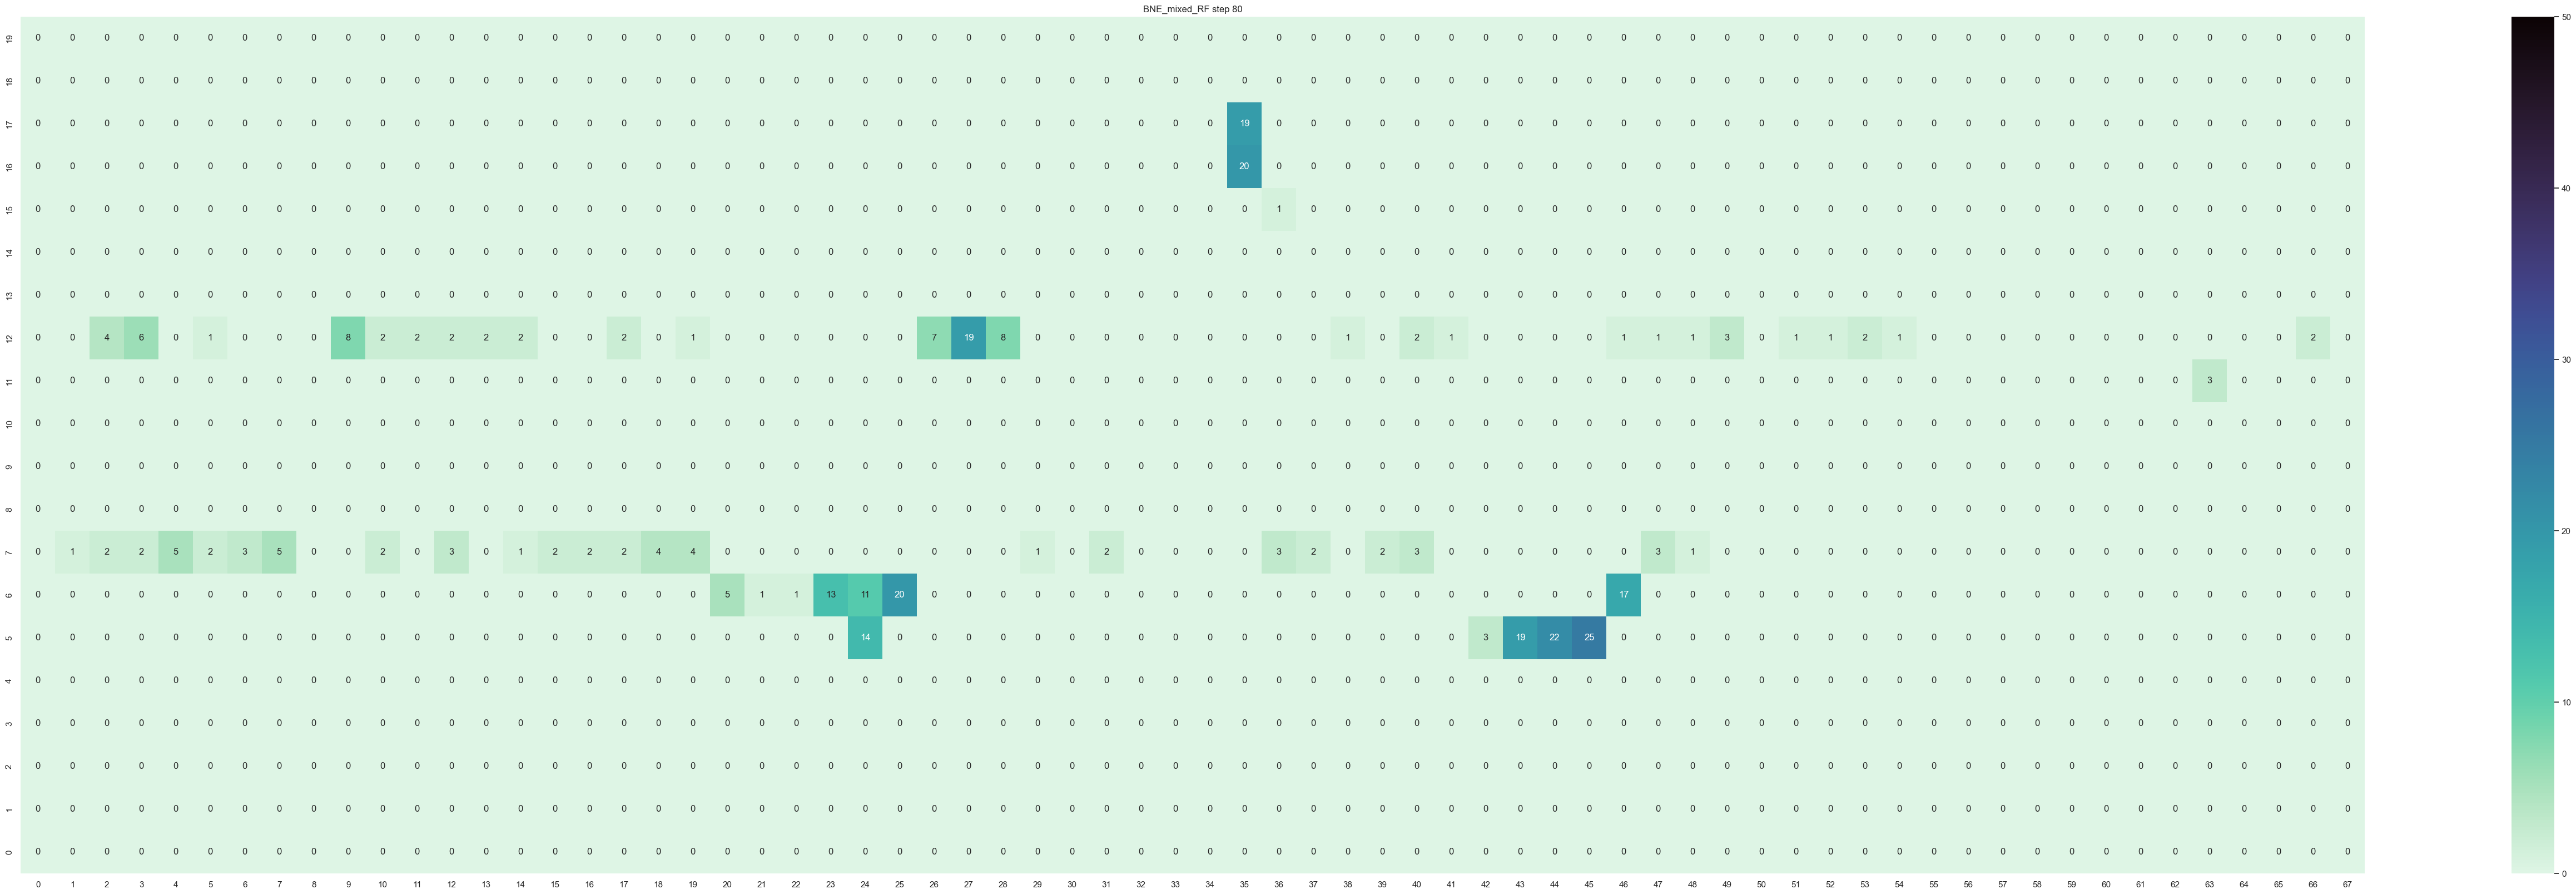

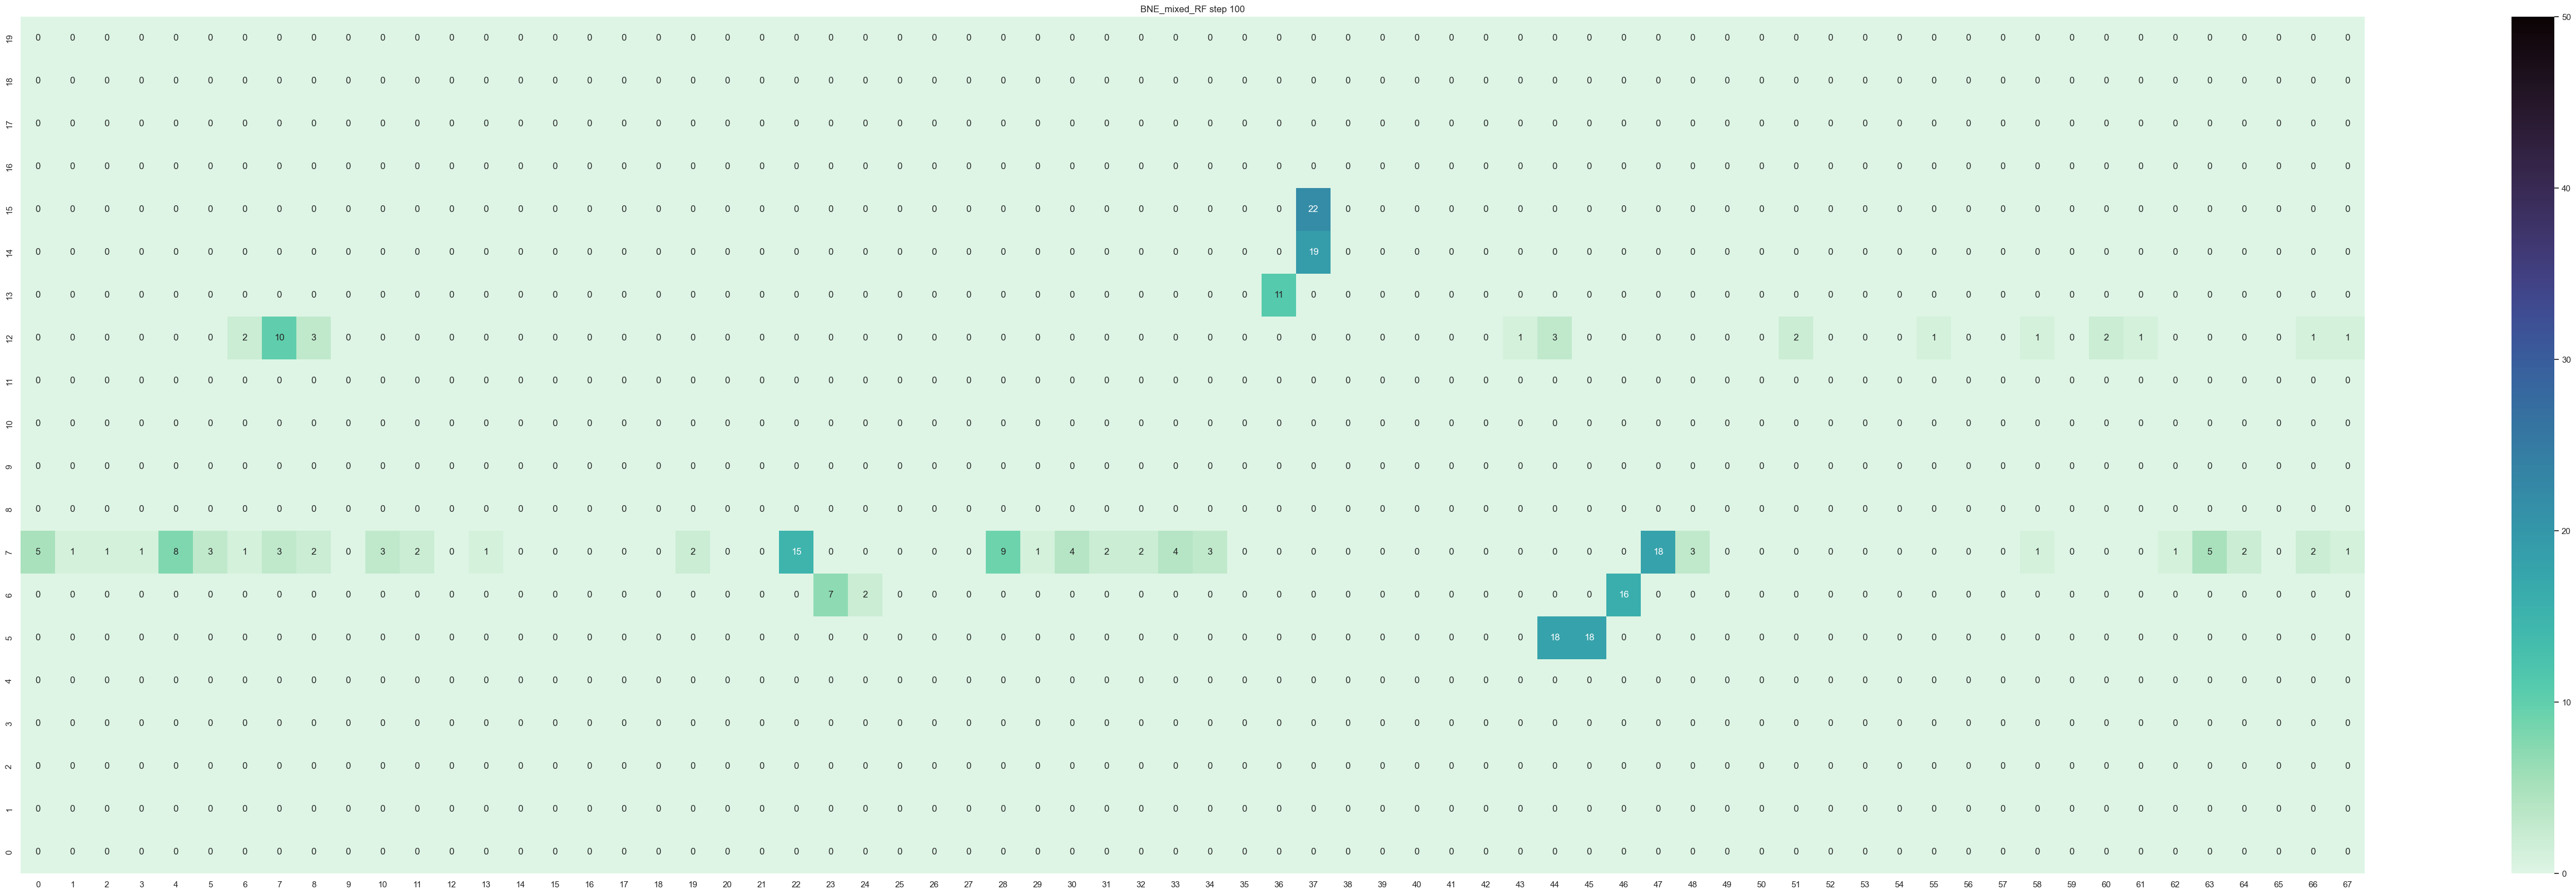

In [65]:
frames(("BNE_mixed_RF", 0))

### Czas ewakuacji w zależności od liczby agentów dla wszystkich metod